# Contains  finalized analyses used in the published Corpse paper - preliminary analyses were removed to make final edits easier, but can be found in v4 - RKR 20250207

In [2]:
# modules to import

import os
import glob
import re

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import seaborn as sns 

import numpy as np
import math as mat
import scipy.stats as scipy
import statsmodels.api as sm

import matplotlib.dates as md
from matplotlib.dates import DateFormatter
import datetime as datetime
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter

import time as time

from collections import defaultdict

import molmass
from molmass import Formula
# if you get an error: No module named 'molmass', run the following: pip install molmass

#if you get weird errors about matplotlib, like certain arguments don't exist, install the following: 
#  pip install --upgrade matplotlib. Most recent version = 3.5.1

In [3]:
# todays date for saving purposes 
today = datetime.date.today().strftime('%Y%m%d')

In [4]:
# setting default font as Arial for everything 
plt.rc('font',family = 'Arial')

### Defining functions to use during the analysis

In [6]:
# function to remove quotes from compound names in column headers
def remove_quotes(text):
    chars_to_replace = "'" # want to remove single quotes
    for char in chars_to_replace:
       text = text.replace(char, "") # replace the defined character with nothing
    return text

# function to read chemical formulas
def parse_formula(chem_formula): # create a function that counts the number of elements in the compound names
    pattern = r'([A-Z][a-z]?)(\d*)' # pattern: Big Letter with potenital second small letter (covers C and He, for example), followed by a # (default 1)
    counts = defaultdict(int) # creates a dictionary of the counted values
    for (element, count) in re.findall(pattern, chem_formula): # recalls the set pattern and then perfroms the count for each compound
        counts[element] += int(count) if count else 1 # starts with a default count of 1 for each element
    return counts

# function to remove the extra H+ from the PTR formulas
def remove_PTR_Hion(list_of_formulas):
    chem_formulas = []   # create an empty list
    for x in list_of_formulas: # for every value in the list:
        formula = parse_formula(x) # apply the chemical formula to each compound 
        num_h = formula.get('H', 0) # get the number of atoms for the 4 elements
        true_h = num_h - 1    # subtract off one H
        num_o = formula.get('O', 0) 
        num_c = formula.get('C', 0)
        num_s = formula.get('S', 0)
        if num_c > 0: # write the values in the proper form for each element
            if num_c == 1:
                carbon = 'C'
            else:
                carbon = 'C' + str(num_c) # convert the numeric value to string format
        else:
            carbon = str('')
        if num_o > 0:
            if num_o == 1:
                oxygen = 'O'
            else:
                oxygen = 'O' + str(num_o)
        else:
            oxygen = str('')
        if num_s > 0:
            if num_s == 1:
                sulfur = 'S'
            else:
                sulfur = 'S' + str(num_s)
        else:
            sulfur = str('')
        if true_h > 0:
            if true_h == 1:
                hydrogen = 'H'
            else:
                hydrogen = 'H' + str(true_h)
        else:
            hydrogen = str('')
        new_formula = carbon + hydrogen + oxygen + sulfur # combine the values together
        chem_formulas.append((new_formula)) # store in the list
    return chem_formulas


# function to calculate number densities from ppb space
avo_constant = 6.022E23
R_constant = 0.08206
def number_density(conc_ppb, temp_c, atm_pr_hpa):
    temp_k = temp_c + 273.13 # conver to K
    pressure_atm = atm_pr_hpa * 0.000987 # convert from hPa to atm
    vol_conv = 1000 # L to mL to cm3
    
    number_density_value = ((conc_ppb * avo_constant * 1E-9) / ((R_constant * temp_k) / pressure_atm)) / vol_conv 
    return(number_density_value)


# function to average data to the GC sampling time blocks
def calc_time_block_stats(df, name): # stats to apply to each df
    stat_funcs = [df.mean, df.std, df.max, df.min, df.median]
    stat_names = ['mean', 'stdev', 'max', 'min', 'median']
    stats = pd.concat( # combining the stats for each sample block into a df and renaming each stat with the correct name
        [pd.DataFrame(func()).transpose().rename(index = {0 : name}) for func, name in zip(stat_funcs, stat_names)] 
    )
    stats.drop(columns = 'datetime', inplace = True) # dropping the datetime column b/c they are sorted by datatime
    stats.index = pd.MultiIndex.from_product([[name], stats.index], names = ['GC_Sample', 'stats']) # adding a multilevel index w/ the df name
    return stats



### Pre-Plot Code to Run

In [8]:
# list of suspected fragment ions (or cmpds without spikes during bloom period) to drop from analyses: 

suspect_frag_ions = ['CHS+', 'CH3S+', 'CH3S2+', 'CH5O3+', 'CH5S2+', 'CH6N2OS+', 'C2H5S+', 'C2H5S2+', 
                     'C2H6S2+', 'C7H11O+', 'S2+', 'CH3O2+', 'C7H7O2+', 'C9H11O2+', 'C9H11O3+', 'CH7OS+'] # edit as needed
suspect_frag_molcs = remove_PTR_Hion(suspect_frag_ions) # apply function to get actual molecule

#### Reading in the PTR datafile

In [10]:
import datetime as datetime # keep getting a weird error and having to reimport this module
 
corpse_ts_file = 'PTR_ppb_All_Cmpds_20241106.csv' # edit as needed # PTR file is saved in the same folder as the code file
corpse_ts = pd.read_csv(corpse_ts_file)
#corpse_ts['datetime'] = pd.to_datetime(corpse_ts['LocalTime'], dayfirst = False) # turning datetime column into pd datetime class
#corpse_ts.drop(columns = ['LocalTime'], inplace = True) # drop old date and time columns

corpse_ts['date'] = pd.to_datetime(corpse_ts['date']) # turn date col into pd.DateTime
corpse_ts['time'] = pd.to_datetime(corpse_ts['time'], format = '%H:%M:%S') # turn time col into pd.DateTime
corpse_ts['time'] = corpse_ts['time'].dt.time # drop weird date format from the time col 

# combine into new datetime col
corpse_ts['datetime'] = corpse_ts.apply(lambda row: datetime.datetime.combine(row['date'], row['time']), axis = 1) 
datetime = corpse_ts['datetime']
corpse_ts.drop(columns = ['LocalTime', 'date', 'time'], inplace = True) # drop old date and time columns

datetime = corpse_ts['datetime']# store datetime for future

# apply remove_quotes function to columns in the corpse df
corpse_ts.columns = [remove_quotes(col) for col in corpse_ts.columns ] 

# re-arranging df so that all S-spp are together
corpse_ts.rename(columns = {'CH5S_actual_ppb' : 'CH5S+'}, inplace = True)
CH5S = corpse_ts.pop('CH5S+')
corpse_ts.insert(2, 'CH5S+', CH5S)
S2 = corpse_ts.pop('S2+')
corpse_ts.insert(2, 'S2+', S2)
C2H7O2S = corpse_ts.pop('C2H7O2S+')
corpse_ts.insert(2, 'C2H7O2S+', C2H7O2S)
C4H9OS = corpse_ts.pop('C4H9OS+')
corpse_ts.insert(2, 'C4H9OS+', C4H9OS)

corpse_ts_PTR_ions = corpse_ts.copy() # saving version containing the PTR ions just in case

# create df with the actual cmpd formula (no PTR H+)
corpse_ts_actual_cmpds = corpse_ts.copy() # no overwriting !
# drop the date time column so it doesn't go through the column function
corpse_ts_actual_cmpds.drop(columns = ['datetime'], inplace = True) 

compound_list = list(corpse_ts_actual_cmpds.columns) # get a list of the compound names (aka each column header)

# apply the function to remove the PTR H+ from each compound name
formula_names = remove_PTR_Hion(compound_list) 

corpse_ts_actual_cmpds.columns = formula_names # rename all the columnds with the new, whole molecule names
corpse_ts_actual_cmpds['datetime'] = datetime # put the datetime column back in the df 

#print(corpse_ts)

C:\Users\rossellr\AppData\Local\Temp\ipykernel_1412\2368276268.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  corpse_ts['date'] = pd.to_datetime(corpse_ts['date']) # turn date col into pd.DateTime


#### Reading in the metadate files

In [12]:
co2_file = 'corpse_CO2_monitor_data.csv' # datafile is stored in the same folder as the source code
co2_ts = pd.read_csv(co2_file)
co2_ts['datetime'] = pd.to_datetime(co2_ts['Time(DD/MM/YYYY H:mm:ss)'], dayfirst = True) # formating the datetime column correctly as a datetime type
co2_ts.drop(columns = ['Time(DD/MM/YYYY H:mm:ss)'], inplace = True) # removing original one
#print(co2_ts)

# reading in the preliminary lifetime and rate constant datafile: 20241017
lifetime_file = 'prelim_lifetimes_rate_constants.csv' # datafile is stored in the same folder as the source code
lifetimes_RateConstants = pd.read_csv(lifetime_file)

#lifetimes_RateConstants.drop([3], inplace = True) # drop C3H7S3+ b/c no data
#lifetimes_RateConstants.reset_index(inplace = True)
#lifetimes_RateConstants.drop(columns = ['index'], inplace = True) # resetting the index is adding an index colum to df that needs to be dropped

#print(lifetimes_RateConstants)

# reading in the GC data
gc_avg_ppb_file = 'gc_cmpds_avg_ppb.csv' # datafile is stored in the same folder as the source code
gc_avg_ppb = pd.read_csv(gc_avg_ppb_file)
gc_avg_ppb['start_datetime'] = gc_avg_ppb['date'] + ' ' + gc_avg_ppb['Start_Time'] # combining into a datetime column
gc_avg_ppb['start_datetime'] = pd.to_datetime(gc_avg_ppb['start_datetime']) # converting to pd datetime class
gc_avg_ppb['end_datetime'] = gc_avg_ppb['date'] + ' ' + gc_avg_ppb['End_Time']
gc_avg_ppb['end_datetime'] = pd.to_datetime(gc_avg_ppb['end_datetime']) 
gc_avg_ppb.drop(columns = ['date', 'Start_Time', 'End_Time'], inplace = True) # dropping for clarity
 
#print(gc_avg_ppb)

#### Analysis code chunks

In [14]:
# seperating the female and male time blocks

female_ts = corpse_ts_PTR_ions.copy() # keeping the PTR formula for the corr matrices
female_ts.set_index('datetime', inplace = True) # set datetime as index to easily splice dataframe
female_ts = female_ts['2024-05-25 18:00:00' : '2024-05-26 9:00:00'] # Female  bloom = 6pm 20240525 to 9am 20240526
female_ts.reset_index(inplace = True) # reset index 

male_ts = corpse_ts_PTR_ions.copy()
male_ts.set_index('datetime', inplace = True) 
male_ts = male_ts['2024-05-26 18:00:00' : '2024-05-27 9:00:00'] # Male  bloom = 6pm 20240526 to 9am 20240527
male_ts.reset_index(inplace = True)
male_ts

,datetime,CHS+,CH3OS+,C4H9OS+,C2H7O2S+,S2+,CH5S+,CH3S+,CH3S2+,CH3S3+,...,C8H15+,CH3O2+,C2H5O2+,C5H11O2+,C7H7O2+,C7H9O+,C8H9O+,C9H11O2+,C9H11O3+,C10H17+
0,2024-05-26 18:00:08,0.004700,0.000973,-0.017765,0.005132,0.001263,0.134046,-0.049195,0.014444,0.001392,...,0.019274,-0.007482,0.606258,0.013803,0.018645,0.010235,0.013452,0.004875,0.002087,0.205656
1,2024-05-26 18:00:18,0.082080,0.000177,-0.017777,0.003069,0.004924,0.110651,0.022028,0.017427,-0.006418,...,0.015734,0.014239,0.561020,0.015232,0.016733,0.009955,0.007634,0.004821,0.002695,0.185236
2,2024-05-26 18:00:28,-0.007689,0.000945,-0.015012,0.003271,0.003578,0.311396,-0.004196,0.012400,0.014162,...,0.014183,0.000902,0.665770,0.015786,0.015572,0.005952,0.010317,0.005474,0.002508,0.178597
3,2024-05-26 18:00:38,0.076396,0.000329,-0.015755,0.004066,0.003673,0.338636,-0.005829,0.020584,-0.004361,...,0.015865,0.008233,0.634639,0.016389,0.016141,0.008219,0.007882,0.000873,-0.000132,0.150683
4,2024-05-26 18:00:48,0.024635,0.000568,-0.017741,0.003071,0.005240,0.185696,-0.001311,0.008173,0.004349,...,0.014985,0.005037,0.566313,0.016009,0.020938,0.007621,0.009631,0.000682,0.002365,0.104396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,2024-05-27 08:59:11,0.032095,0.000040,0.005550,0.009923,0.000284,0.172055,0.001834,0.002270,-0.008513,...,0.038138,-0.005423,1.000610,0.015358,0.006754,0.023988,0.026144,0.001321,0.000722,0.288332
5181,2024-05-27 08:59:21,0.030175,0.001090,-0.001455,0.011551,0.000584,0.114472,0.013812,0.004691,0.000022,...,0.041378,-0.026499,1.024650,0.014772,0.007354,0.019240,0.027266,0.002219,0.000606,0.305039
5182,2024-05-27 08:59:31,0.020208,0.000821,0.006636,0.011900,0.000951,0.035990,0.006642,0.000255,-0.009503,...,0.042757,-0.009106,1.051530,0.012774,0.008198,0.017629,0.031448,0.004412,-0.000573,0.304993
5183,2024-05-27 08:59:41,0.039934,-0.000124,-0.001308,0.014208,-0.000563,0.040773,0.030199,0.005411,-0.000774,...,0.040241,-0.007408,1.095650,0.012748,0.012111,0.019055,0.033046,0.001033,0.000317,0.293040


In [15]:
# summing the totals of each compound for the male and female emission periods (all PTR traces)

total_female_emissions = female_ts.copy() # no overwriting !
total_female_emissions.drop(columns = ['datetime'], inplace = True) # don't need datetime
total_female_emissions = pd.DataFrame(total_female_emissions.sum()) # add every row per column
total_female_emissions.rename(columns = {0 : 'total_compound_amt_ppb_female'}, inplace = True) # rename the column
total_female_emissions = pd.DataFrame(total_female_emissions) # dataframe it up

total_male_emissions = male_ts.copy() # rinse and repeat
total_male_emissions.drop(columns = ['datetime'], inplace = True)
total_male_emissions = pd.DataFrame(total_male_emissions.sum())
total_male_emissions.rename(columns = {0 : 'total_compound_amt_ppb_male'}, inplace = True)
total_male_emissions = pd.DataFrame(total_male_emissions)

male_vs_female_totals = pd.concat([total_female_emissions, total_male_emissions], axis = 1).reindex(total_female_emissions.index) # concat the df 
male_vs_female_totals.index.name = 'compound' # index by compound name to make future concats easier

male_vs_female_totals = male_vs_female_totals.transpose() # rotate that bitch so male and female are the row headings - makes bar graphs easier
#print(male_vs_female_totals)


### Preliminary Lifetime/Rate Constant Data

#### Vapor Pressure 

In [18]:
# examining male vs female bloom emissions vs compound vapor pressure

ordered_vp = lifetimes_RateConstants.copy() # no over-writing !
ordered_vp = ordered_vp.sort_values(by = 'vapor_pressure_mmHg', ascending = True) # sorting by vapor pressure
ordered_vp.rename(columns = {'cmpd_PTR_formula' : 'compound'}, inplace = True) # re-name column for future concatting
cmpds_with_info = ordered_vp['compound'] # get list of compound names to splice the male and female totals df
ordered_vp.set_index('compound', inplace = True) # set as index for future concatting

# need male and female totals for only the compounds we have data from

copy = male_vs_female_totals.copy() # no over-writing !
vp_cmpds_male_female = copy[cmpds_with_info] # splicing to only include compounds that we have data for
vp_cmpds_male_female = vp_cmpds_male_female.transpose() # flip df so compounds are now the index for future concatting
female_totals = vp_cmpds_male_female['total_compound_amt_ppb_female'].sum() # sum of all of the compounds emitted during the female bloom
male_totals = vp_cmpds_male_female['total_compound_amt_ppb_male'].sum() # sum of all of the compounds emitted during the male bloom
vp_cmpds_male_female['cmpd_percent_female'] =  vp_cmpds_male_female['total_compound_amt_ppb_female'] / female_totals * 100 # might want percentage 
vp_cmpds_male_female['cmpd_percent_male'] =  vp_cmpds_male_female['total_compound_amt_ppb_male'] / male_totals * 100

vp_react_emission_concat = pd.concat([ordered_vp, vp_cmpds_male_female], axis = 1)
vp_react_emission_concat['k_o3_298K'] = vp_react_emission_concat['k_o3_298K'].fillna(0)
#print(vp_react_emission_concat)

#print(lifetimes_RateConstants)

In [19]:
cmpds_to_sort = ['CH5S+', 'C2H7S+', 'C2H7S3+', 'C2H7S2+']
cmpd_names = ['MeSH', 'DMS', 'DMTS', 'DMDS']
df = pd.DataFrame(cmpds_to_sort, columns = ['compound'])

copy = vp_react_emission_concat.copy()
big_s_cmpds = copy.loc[cmpds_to_sort]
big_s_cmpds['cmpd_names'] = cmpd_names
big_s_VP = [1.51E3, 479, 1.1, 24.5]
big_s_cmpds['vp_mmHg'] = big_s_VP
big_s_cmpds = big_s_cmpds.sort_values(by = 'vp_mmHg', axis = 0, ascending = False)

#print(big_s_cmpds)

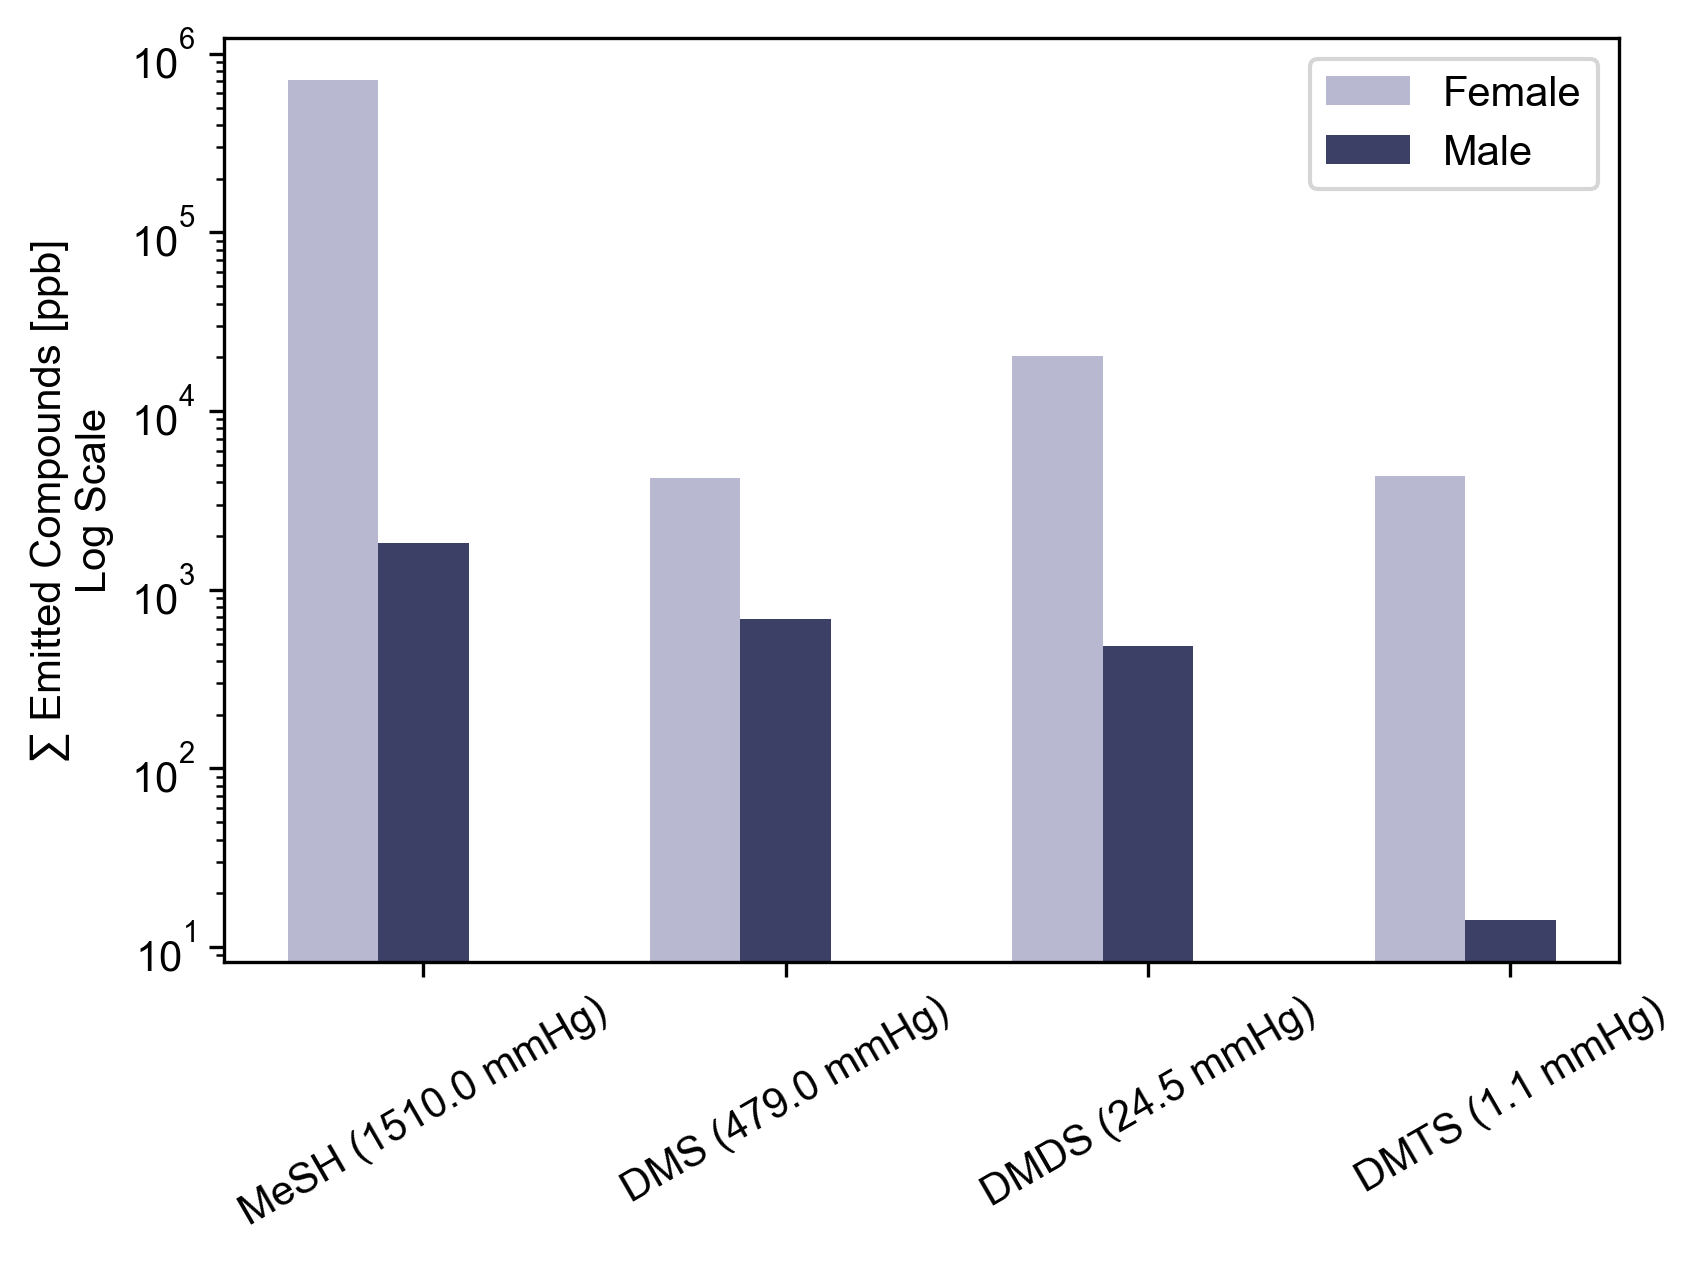

In [20]:
# VP vs main S cmpds


xlabels = big_s_cmpds['cmpd_names'] + ' (' + big_s_cmpds['vp_mmHg'].astype(str) + ' mmHg)' # combining VP w/ name for visualization
xticks  = big_s_cmpds['cmpd_names']

width = 0.25
labels = big_s_cmpds.index

br1 = np.arange(len(big_s_cmpds['total_compound_amt_ppb_female']))
br2 = [x + width for x in br1]

fig, ax = plt.subplots(figsize = (6,4), dpi = 300)

plt.bar(br1, big_s_cmpds['total_compound_amt_ppb_female'], width = width, label = 'Female', color = '#B8B8D1')
plt.bar(br2, big_s_cmpds['total_compound_amt_ppb_male'], width = width, label = 'Male', color = '#3D4066')

plt.xticks([r + width for r in range(len(big_s_cmpds['total_compound_amt_ppb_female']))], xlabels, rotation = 30)
plt.yscale('log')
plt.legend(loc = 'upper right')
plt.ylabel('∑ Emitted Compounds [ppb]\nLog Scale')

save_path = 'C:\\Users\\rossellr\\OneDrive - Colostate\\Desktop\\CSU\\Research\\Research Projects\\Plants\\CORPSE\\Python\\Fig_Outputs'
fig_name = 'MaleVsFemale_VP_logScale_' + today + '.png'
fig_save_path = save_path + "/" + fig_name
#plt.savefig(fname = fig_save_path, bbox_inches = 'tight') #keeps legend included when outputting figure

plt.show()


### Reactivities at midnight

In [22]:
cmpd_names = vp_react_emission_concat.index # need list of cmpds that we have data for
cmpds = corpse_ts_PTR_ions.copy() # no over writing !
co2_copy = co2_ts.copy()

# splicing the CO2 data into male and female bloom times 

co2_female = co2_copy.copy()
co2_female.set_index('datetime', inplace = True) # setting index to dt class for splicing 
co2_female = co2_female.loc['2024-05-25 18:01' : '2024-05-26 9:00'] # splice dataset to female times (6pm to 9am)
co2_female.reset_index(inplace = True) 
co2_female.rename(columns = {'datetime' : 'datetime_co2'}, inplace = True) # just in case we get confused later
co2_female['datetime_co2'] = co2_female['datetime_co2'].dt.strftime('%Y-%m-%d %H:%M') # re-formatting the time 

co2_male = co2_copy.copy() # rinse and repeat
co2_male.set_index('datetime', inplace = True)
co2_male.index = pd.to_datetime(co2_male.index)
co2_male = co2_male.loc['2024-05-25 18:01' : '2024-05-26 9:00']
co2_male.reset_index(inplace = True)
co2_male.rename(columns = {'datetime' : 'datetime_co2'}, inplace = True)
co2_male['datetime_co2'] = co2_male['datetime_co2'].dt.strftime('%Y-%m-%d %H:%M')

# need to re-sample the emission data by 2 min to match the CO2 data

female_2min_avg = cmpds.copy()
female_2min_avg.set_index('datetime', inplace = True) # setting index to dt class for splicing 
female_2min_avg = female_2min_avg['2024-05-25 18:01:00' : '2024-05-26 9:00:00'] # Female  bloom = 6pm to 9am 
female_2min_avg = female_2min_avg.resample('2min', offset = '1min').mean() 
female_2min_avg.reset_index(inplace = True) # resampling sets the datetime col to the index, so need to re-index
female_2min_avg['datetime'] = female_2min_avg['datetime'].dt.strftime('%Y-%d-%m %H:%M') # round to every minute
female_2min_avg.rename(columns = {'datetime' : 'datetime_cmpds'}, inplace = True)
#print(female_2min_avg)


male_2min_avg = cmpds.copy()
male_2min_avg.set_index('datetime', inplace = True) # setting index to dt class for splicing 
male_2min_avg = male_2min_avg['2024-05-26 18:01:00' : '2024-05-27 9:00:00'] # Male  bloom = 6pm to 9am 
male_2min_avg = male_2min_avg.resample('2min', offset = '1min').mean() 
male_2min_avg.reset_index(inplace = True) # resampling sets the datetime col to the index, so need to re-index
male_2min_avg['datetime'] = male_2min_avg['datetime'].dt.strftime('%Y-%d-%m %H:%M') # round to every minute
male_2min_avg.rename(columns = {'datetime' : 'datetime_cmpds'}, inplace = True)
#print(male_2min_avg)


# converting from ppb to number density 

female_num_den = female_2min_avg.copy() 
for index, row in female_num_den.iterrows(): # applying number density function defined above, using data from the correct CO2 df
    temp_c = co2_female.loc[index, 'Temperature(°C)']
    atm_pr_hpa = co2_female.loc[index, 'Atmospheric pressure(hPa)']

    for col in row.index:
         if pd.api.types.is_numeric_dtype(female_num_den[col]):
             female_num_den.at[index, col] = number_density(
                 row[col],
                 temp_c,
                 atm_pr_hpa
             )
female_number_den = female_num_den.copy()

male_num_den = male_2min_avg.copy()
for index, row in male_num_den.iterrows(): # applying number density function defined above, using data from the correct CO2 df
    temp_c = co2_male.loc[index, 'Temperature(°C)']
    atm_pr_hpa = co2_male.loc[index, 'Atmospheric pressure(hPa)']

    for col in row.index:
         if pd.api.types.is_numeric_dtype(male_num_den[col]):
             male_num_den.at[index, col] = number_density(
                 row[col],
                 temp_c,
                 atm_pr_hpa
             )
male_number_den = male_num_den.copy()



In [23]:
# only calculating reactivites at midnight

# first, need to extract the row that contains only the data for midnight
copy = female_num_den.copy()
female_midnight = copy.loc[(copy['datetime_cmpds'] >= '2024-25-05 23:55')
    & (copy['datetime_cmpds'] < '2024-26-05 00:05')]
female_midnight = female_midnight.loc[[179]] # selecting index # 179 b/c that is closest to midnight
female_midnight.drop(columns = ['datetime_cmpds'], inplace = True) # dropping datetime col 
female_midnight_reactivies = female_midnight[cmpd_names] # only pulling out compounds we have data for
female_midnight_reactivies = female_midnight_reactivies.transpose() # want cmpds as row labels
female_midnight_reactivies.rename(columns = {179 : 'female_num_den_midnight'}, inplace = True) # renaming num den column
female_midnight_reactivies['no3_reactivity_1/s'] = vp_react_emission_concat['k_no3_298K'] * female_midnight_reactivies['female_num_den_midnight'] 
female_midnight_reactivies['o3_reactivity_1/s'] = vp_react_emission_concat['k_o3_298K'] * female_midnight_reactivies['female_num_den_midnight']
female_midnight_reactivies['oh_reactivity_1/s'] = vp_react_emission_concat['k_OH_298K'] * female_midnight_reactivies['female_num_den_midnight']
female_midnight_reactivies['proposed_cmpd_name'] = vp_react_emission_concat['proposed_cmpd_name'] # want the actual names to come too
# contribution of each compound to the total reactivity
female_no3_total_midnight = female_midnight_reactivies['no3_reactivity_1/s'].sum()
female_midnight_reactivies['no3_reactivity_percent'] = female_midnight_reactivies['no3_reactivity_1/s'] / female_no3_total_midnight * 100
female_o3_total_midnight = female_midnight_reactivies['o3_reactivity_1/s'].sum()
female_midnight_reactivies['o3_reactivity_percent'] = female_midnight_reactivies['o3_reactivity_1/s'] / female_o3_total_midnight * 100
female_oh_total_midnight = female_midnight_reactivies['oh_reactivity_1/s'].sum()
female_midnight_reactivies['oh_reactivity_percent'] = female_midnight_reactivies['oh_reactivity_1/s'] / female_oh_total_midnight * 100
female_midnight_reactivies.reset_index(inplace = True)
female_midnight_reactivies.rename(columns = {'index' : 'compounds'}, inplace = True)


copy = male_num_den.copy()
male_midnight = copy.loc[(copy['datetime_cmpds'] >= '2024-26-05 23:55')
    & (copy['datetime_cmpds'] < '2024-27-05 00:05')]
male_midnight = male_midnight.loc[[179]] # selecting index # 179 b/c that is closest to midnight
male_midnight.drop(columns = ['datetime_cmpds'], inplace = True)
male_midnight_reactivies = male_midnight[cmpd_names] # only pulling out compounds we have data for
male_midnight_reactivies = male_midnight_reactivies.transpose() # want cmpds as row labels
male_midnight_reactivies.rename(columns = {179 : 'male_num_den_midnight'}, inplace = True) # renaming num den column
male_midnight_reactivies['no3_reactivity_1/s'] = vp_react_emission_concat['k_no3_298K'] * male_midnight_reactivies['male_num_den_midnight'] 
male_midnight_reactivies['o3_reactivity_1/s'] = vp_react_emission_concat['k_o3_298K'] * male_midnight_reactivies['male_num_den_midnight']
male_midnight_reactivies['oh_reactivity_1/s'] = vp_react_emission_concat['k_OH_298K'] * male_midnight_reactivies['male_num_den_midnight']
male_midnight_reactivies['proposed_cmpd_name'] = vp_react_emission_concat['proposed_cmpd_name'] # want the actual names to come too
# contribution of each compound to the total reactivity
male_no3_total_midnight = male_midnight_reactivies['no3_reactivity_1/s'].sum()
male_midnight_reactivies['no3_reactivity_percent'] = male_midnight_reactivies['no3_reactivity_1/s'] / male_no3_total_midnight * 100
male_o3_total_midnight = male_midnight_reactivies['o3_reactivity_1/s'].sum()
male_midnight_reactivies['o3_reactivity_percent'] = male_midnight_reactivies['o3_reactivity_1/s'] / male_o3_total_midnight * 100
male_oh_total_midnight = male_midnight_reactivies['oh_reactivity_1/s'].sum()
male_midnight_reactivies['oh_reactivity_percent'] = male_midnight_reactivies['oh_reactivity_1/s'] / male_oh_total_midnight * 100
male_midnight_reactivies.reset_index(inplace = True)
male_midnight_reactivies.rename(columns = {'index' : 'compounds'}, inplace = True)

#print(vp_react_emission_concat)
#print(male_midnight_reactivies)

female_midnight_no3_total_sec = female_midnight_reactivies['no3_reactivity_1/s'].sum()
male_midnight_no3_total_sec = male_midnight_reactivies['no3_reactivity_1/s'].sum()
female_midnight_o3_total_days = female_midnight_reactivies['o3_reactivity_1/s'].sum() * 3600 * 24
male_midnight_o3_total_days = male_midnight_reactivies['o3_reactivity_1/s'].sum() * 3600 * 24
female_midnight_o3_total_sec = female_midnight_reactivies['o3_reactivity_1/s'].sum() 
male_midnight_o3_total_sec = male_midnight_reactivies['o3_reactivity_1/s'].sum() 
female_midnight_oh_total_sec = female_midnight_reactivies['oh_reactivity_1/s'].sum()
male_midnight_oh_total_sec = male_midnight_reactivies['oh_reactivity_1/s'].sum()

#print('{:0.3e}'.format(female_midnight_o3_total_sec))
#print('{:0.3e}'.format(male_midnight_o3_total_sec))

In [24]:
# what if we only want the top 3 reactive compounds?

# top 3 NO3 reactive cmpds (female)
top_female_no3_reactivies_1 = female_midnight_reactivies.sort_values('no3_reactivity_percent', ascending = False)
top_female_reactivies = top_female_no3_reactivies_1[:2].copy() # selecting top 2
others_df = pd.DataFrame(data = {
    'compounds' : ['Other'], # naming the other cmpds
    'proposed_cmpd_name' : ['Other'],
    'female_num_den_midnight' : [top_female_no3_reactivies_1['female_num_den_midnight'][2:].sum()], # adding up the remaining cmpds (not top 3)
    'no3_reactivity_1/s' : [top_female_no3_reactivies_1['no3_reactivity_1/s'][2:].sum()],
    'no3_reactivity_percent' : [top_female_no3_reactivies_1['no3_reactivity_percent'][2:].sum()],
    'o3_reactivity_1/s' : [top_female_no3_reactivies_1['o3_reactivity_1/s'][2:].sum()], # not relevant but need to include b/c they r in the other df
    'o3_reactivity_percent' : [top_female_no3_reactivies_1['o3_reactivity_percent'][2:].sum()],
    'oh_reactivity_1/s' : [top_female_no3_reactivies_1['oh_reactivity_1/s'][2:].sum()],
    'oh_reactivity_percent' : [top_female_no3_reactivies_1['oh_reactivity_percent'][2:].sum()],
     })
top_female_no3_reactivies = pd.concat([top_female_reactivies, others_df])
#print(top_female_no3_reactivies)

# top 3 O3 reactive cmpds (female)
top_female_o3_reactivies_1 = female_midnight_reactivies.sort_values('o3_reactivity_percent', ascending = False)
top_female_reactivies = top_female_o3_reactivies_1[:2].copy() # selecting top 2
others_df = pd.DataFrame(data = {
    'compounds' : ['Other'],
    'proposed_cmpd_name' : ['Other'],
    'female_num_den_midnight' : [top_female_o3_reactivies_1['female_num_den_midnight'][2:].sum()], # adding up the remaining cmpds (not top 3)
    'no3_reactivity_1/s' : [top_female_o3_reactivies_1['no3_reactivity_1/s'][2:].sum()], # not relevant but need to include b/c they r in the other df
    'no3_reactivity_percent' : [top_female_o3_reactivies_1['no3_reactivity_percent'][2:].sum()],
    'o3_reactivity_1/s' : [top_female_o3_reactivies_1['o3_reactivity_1/s'][2:].sum()],
    'o3_reactivity_percent' : [top_female_o3_reactivies_1['o3_reactivity_percent'][2:].sum()],
     'oh_reactivity_1/s' : [top_female_o3_reactivies_1['oh_reactivity_1/s'][2:].sum()],
    'oh_reactivity_percent' : [top_female_o3_reactivies_1['oh_reactivity_percent'][2:].sum()],
    })
top_female_o3_reactivies = pd.concat([top_female_reactivies, others_df])
top_female_o3_reactivies[top_female_o3_reactivies['o3_reactivity_percent'] < 0] = False # getting -% so setting negative values to False for graphing
#print(top_female_o3_reactivies)


# top 3 NO3 reactive cmpds (male)
top_male_no3_reactivies_1 = male_midnight_reactivies.sort_values('no3_reactivity_percent', ascending = False)
top_male_reactivies = top_male_no3_reactivies_1[:2].copy()
others_df = pd.DataFrame(data = {
    'compounds' : ['Other'],
    'proposed_cmpd_name' : ['Other'],
    'male_num_den_midnight' : [top_male_no3_reactivies_1['male_num_den_midnight'][2:].sum()],
    'no3_reactivity_1/s' : [top_male_no3_reactivies_1['no3_reactivity_1/s'][2:].sum()],
    'no3_reactivity_percent' : [top_male_no3_reactivies_1['no3_reactivity_percent'][2:].sum()],
    'o3_reactivity_1/s' : [top_male_no3_reactivies_1['o3_reactivity_1/s'][2:].sum()],
    'o3_reactivity_percent' : [top_male_no3_reactivies_1['o3_reactivity_percent'][2:].sum()],
    'oh_reactivity_1/s' : [top_male_no3_reactivies_1['oh_reactivity_1/s'][2:].sum()],
    'oh_reactivity_percent' : [top_male_no3_reactivies_1['oh_reactivity_percent'][2:].sum()],
    })
top_male_no3_reactivies = pd.concat([top_male_reactivies, others_df])
#print(top_male_no3_reactivies)

# top 3 O3 reactive cmpds (male)
top_male_o3_reactivies_1 = male_midnight_reactivies.sort_values('o3_reactivity_percent', ascending = False)
top_male_reactivies = top_male_o3_reactivies_1[:2].copy()
others_df = pd.DataFrame(data = {
    'compounds' : ['Other'],
    'proposed_cmpd_name' : ['Other'],
    'male_num_den_midnight' : [top_male_o3_reactivies_1['male_num_den_midnight'][2:].sum()],
    'no3_reactivity_1/s' : [top_male_o3_reactivies_1['no3_reactivity_1/s'][2:].sum()],
    'no3_reactivity_percent' : [top_male_o3_reactivies_1['no3_reactivity_percent'][2:].sum()],
    'o3_reactivity_1/s' : [top_male_o3_reactivies_1['o3_reactivity_1/s'][2:].sum()],
   'o3_reactivity_percent' : [top_male_o3_reactivies_1['o3_reactivity_percent'][2:].sum()],
     'o3_reactivity_1/s' : [top_male_o3_reactivies_1['o3_reactivity_1/s'][2:].sum()],
   'o3_reactivity_percent' : [top_male_o3_reactivies_1['o3_reactivity_percent'][2:].sum()],
    })
top_male_o3_reactivies = pd.concat([top_male_reactivies, others_df])



# top 3 OH reactive cmpds (feale)
top_female_oh_reactivies_1 = female_midnight_reactivies.sort_values('oh_reactivity_percent', ascending = False)
top_female_reactivies = top_female_oh_reactivies_1[:2].copy()
others_df = pd.DataFrame(data = {
    'compounds' : ['Other'],
    'proposed_cmpd_name' : ['Other'],
    'female_num_den_midnight' : [top_female_oh_reactivies_1['female_num_den_midnight'][2:].sum()],
    'no3_reactivity_1/s' : [top_female_oh_reactivies_1['no3_reactivity_1/s'][2:].sum()],
    'no3_reactivity_percent' : [top_female_oh_reactivies_1['no3_reactivity_percent'][2:].sum()],
    'o3_reactivity_1/s' : [top_female_oh_reactivies_1['o3_reactivity_1/s'][2:].sum()],
   'o3_reactivity_percent' : [top_female_oh_reactivies_1['o3_reactivity_percent'][2:].sum()],
    'oh_reactivity_1/s' : [top_female_oh_reactivies_1['oh_reactivity_1/s'][2:].sum()],
    'oh_reactivity_percent' : [top_female_oh_reactivies_1['oh_reactivity_percent'][2:].sum()],
    })
top_female_oh_reactivies = pd.concat([top_female_reactivies, others_df])
#print(top_female_no3_reactivies)

# top 3 OH reactive cmpds (male)
top_male_oh_reactivies_1 = male_midnight_reactivies.sort_values('oh_reactivity_percent', ascending = False)
top_male_reactivies = top_male_oh_reactivies_1[:2].copy()
others_df = pd.DataFrame(data = {
    'compounds' : ['Other'],
    'proposed_cmpd_name' : ['Other'],
    'male_num_den_midnight' : [top_male_oh_reactivies_1['male_num_den_midnight'][2:].sum()],
    'no3_reactivity_1/s' : [top_male_oh_reactivies_1['no3_reactivity_1/s'][2:].sum()],
    'no3_reactivity_percent' : [top_male_oh_reactivies_1['no3_reactivity_percent'][2:].sum()],
    'o3_reactivity_1/s' : [top_male_oh_reactivies_1['o3_reactivity_1/s'][2:].sum()],
    'o3_reactivity_percent' : [top_male_oh_reactivies_1['o3_reactivity_percent'][2:].sum()],
    'oh_reactivity_1/s' : [top_male_oh_reactivies_1['oh_reactivity_1/s'][2:].sum()],
    'oh_reactivity_percent' : [top_male_oh_reactivies_1['oh_reactivity_percent'][2:].sum()],
    })
top_male_oh_reactivies = pd.concat([top_male_reactivies, others_df])

#print(top_male_oh_reactivies)

In [25]:
print(top_male_no3_reactivies['no3_reactivity_1/s'].sum())


0.05394491476810259


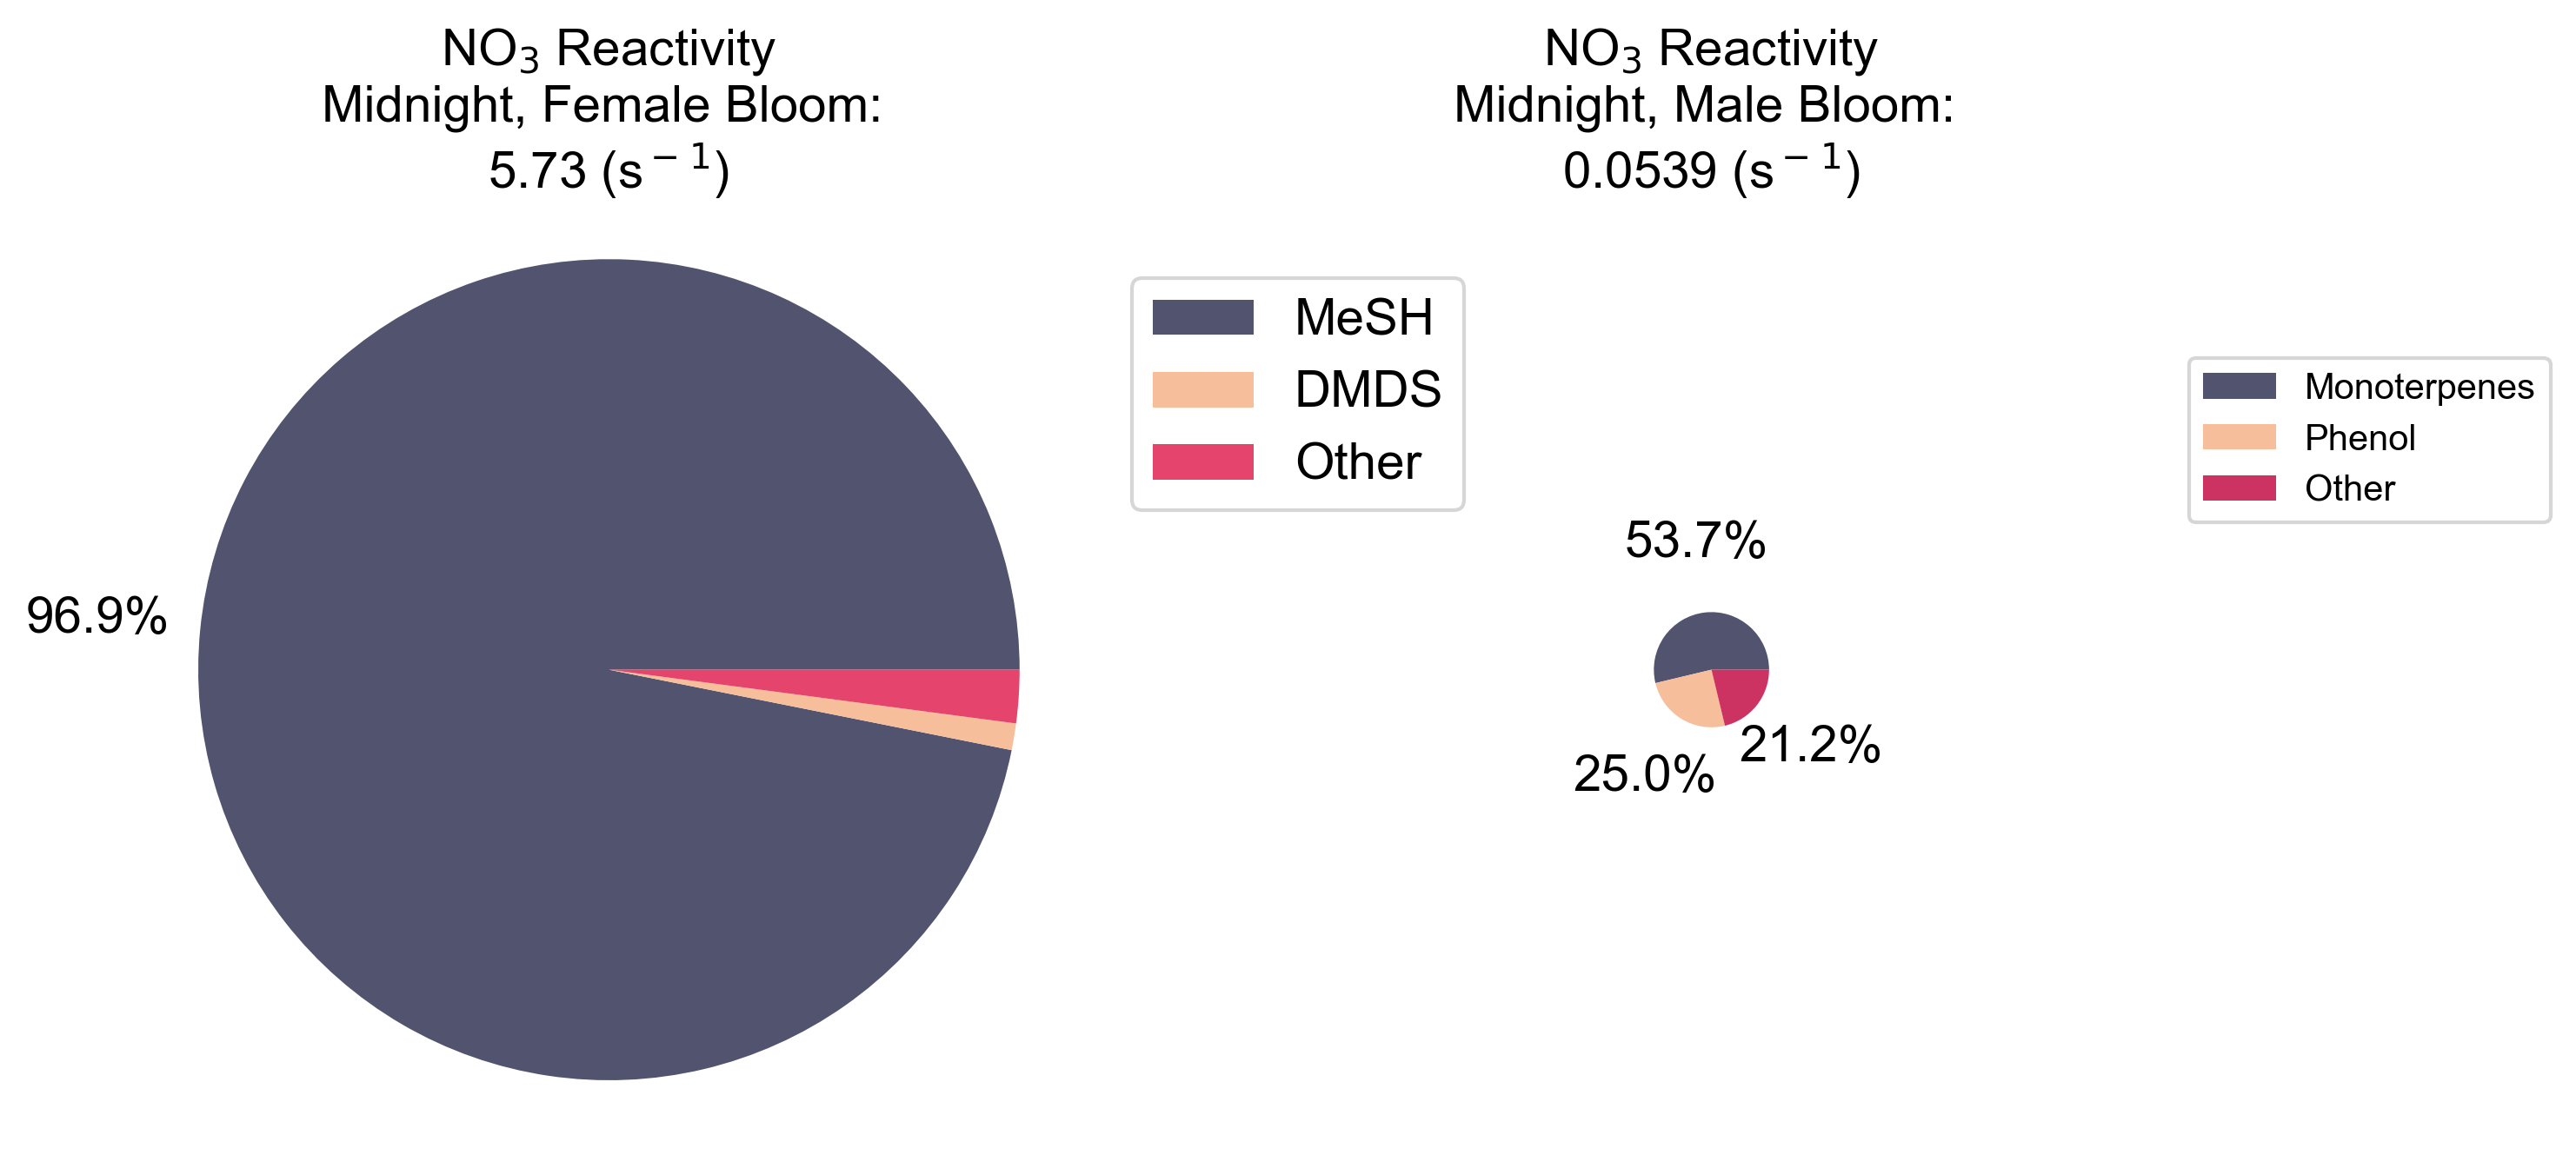

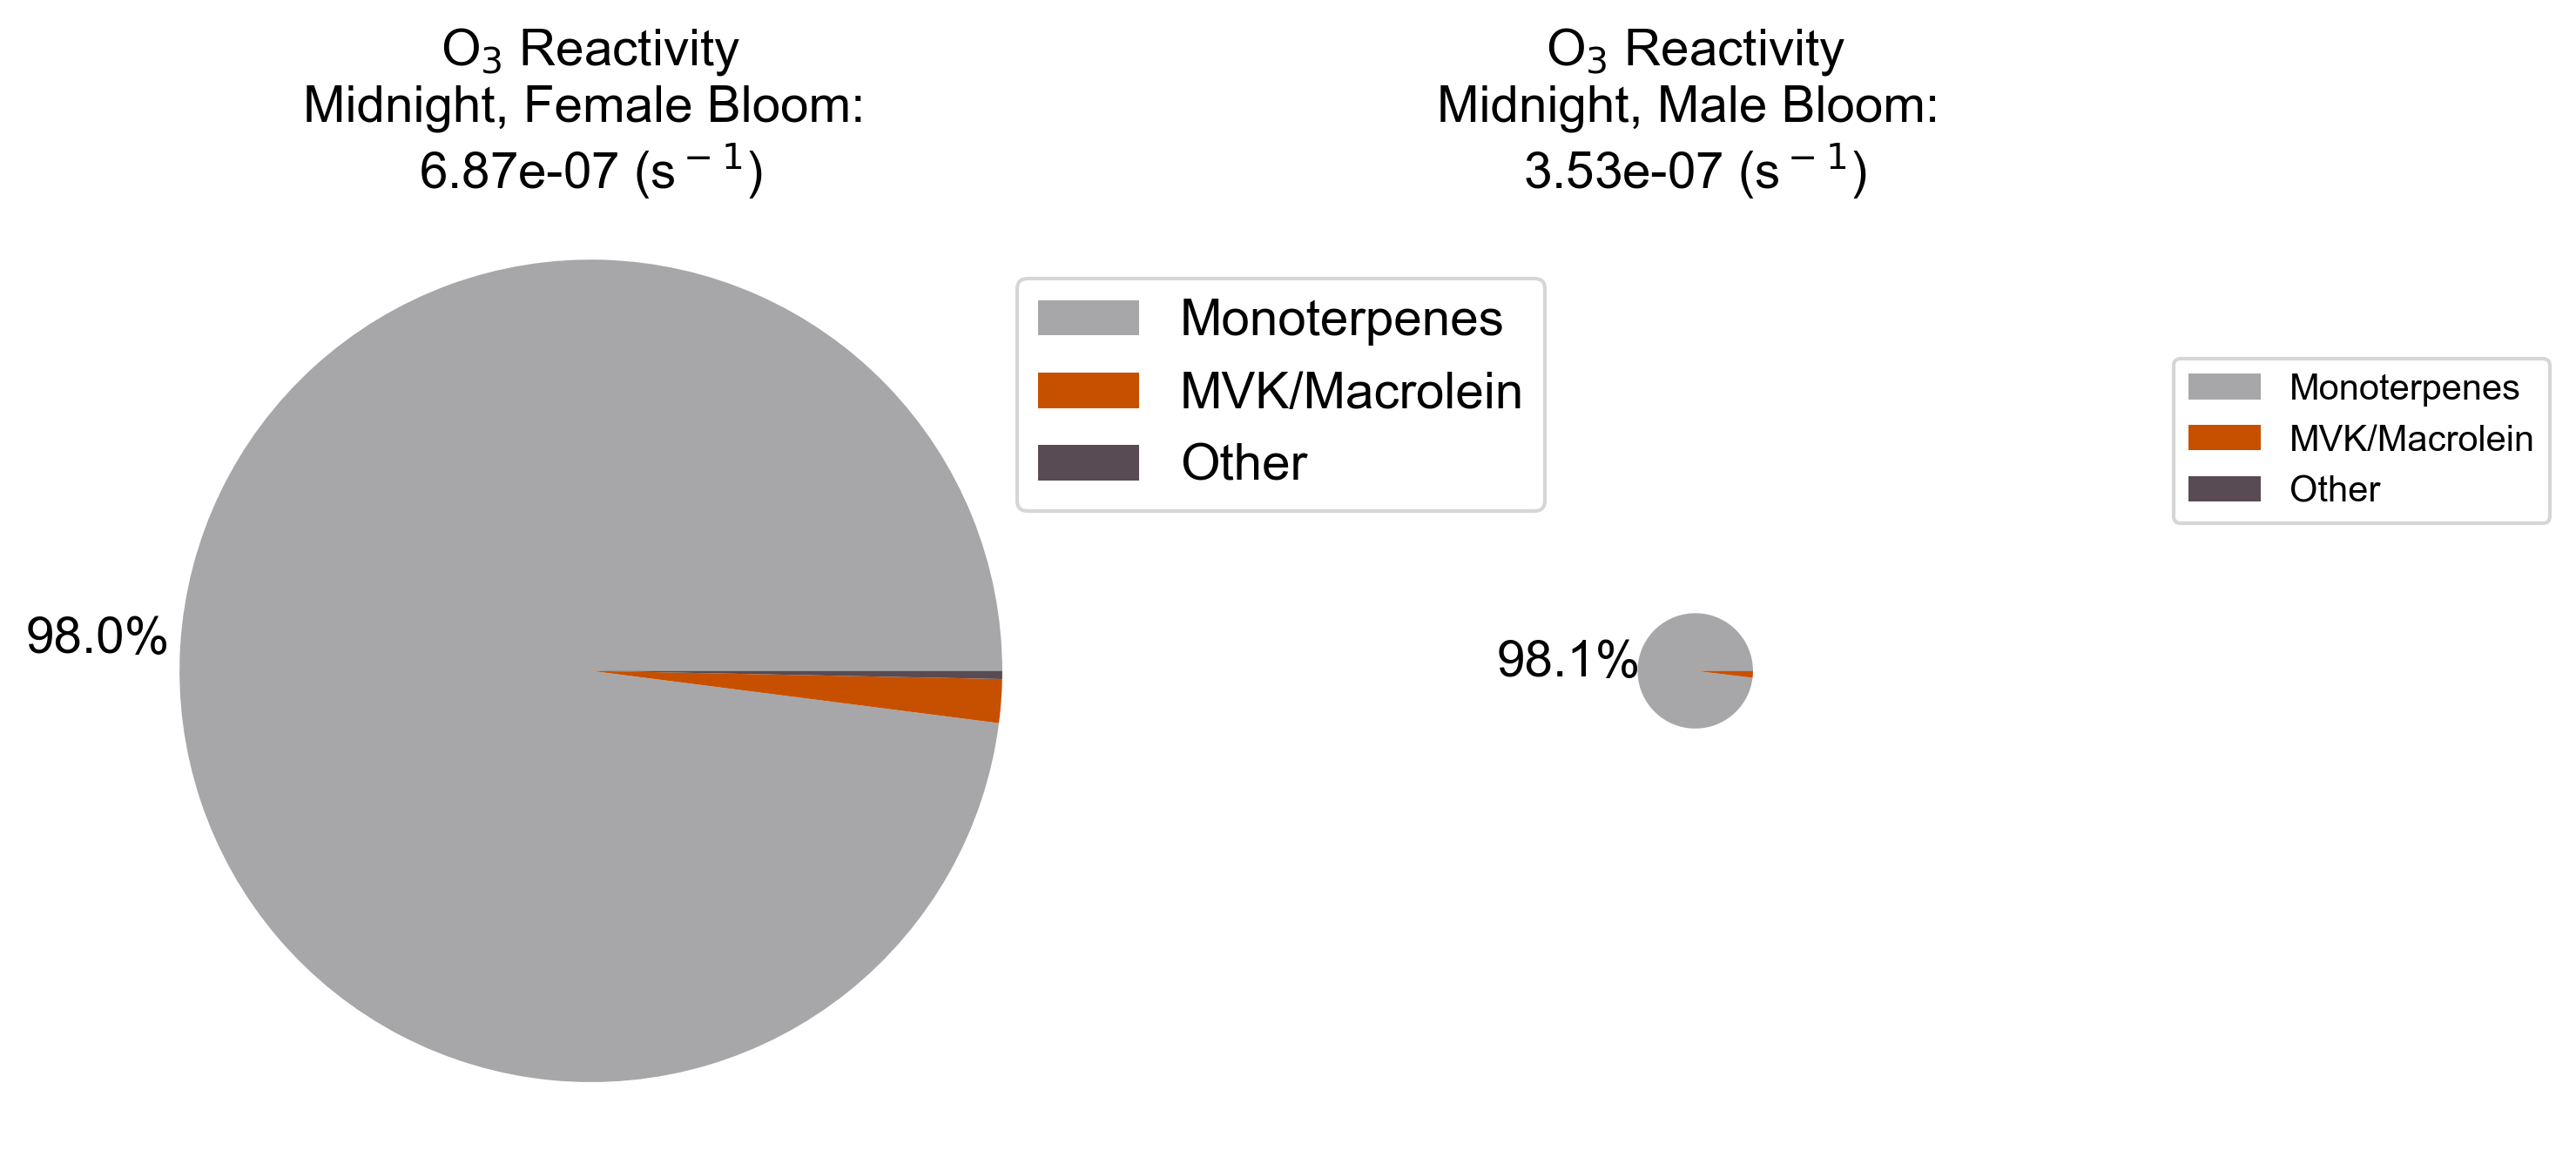

In [26]:
# changing size of plot to reflect total amount of emitted cmpds during the bloom stage 

totals_df = male_vs_female_totals.transpose()
total_female_ppb = totals_df['total_compound_amt_ppb_female'].sum()
total_male_ppb = totals_df['total_compound_amt_ppb_male'].sum()
total = total_female_ppb + total_male_ppb

base_radius = 0.2 # sizing scale factor for area of plots

female_area_scale_factor = total_female_ppb  / total * 100 # sized by the percentage of total emissions
male_area_scale_factor = total_male_ppb  / total * 100

female_radius_scale_factor = mat.sqrt((female_area_scale_factor / mat.pi)) # turning area into radius for sizing
male_radius_scale_factor = mat.sqrt((male_area_scale_factor / mat.pi))

no_labels = ['', '', ''] # removing labels from the individual wedges for clarity

# NO3 reactivities for male and female
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 12), dpi = 300) # 300 dpi is required for most publications

ax1.pie(top_female_no3_reactivies['no3_reactivity_percent'], 
        labels = no_labels, # labels will label each pie slice 
        pctdistance = 1.25, # setting distance of the percents from the chart
        radius =  base_radius * female_radius_scale_factor,
        autopct = lambda pct: '{:1.1f}%'.format(pct) if pct > 5 else '', # setting limits to what percentages are shown
        colors = ['#51536F', '#F6BE9A', '#E5446D'],
      #  hatch = ['', '', '//'], # only want hatch on pink slice to increase visibility of printed images
        textprops = {'fontsize' : 14} 
       )

ax1.legend(loc = 'center',
           bbox_to_anchor = (1, 0.2, 0.5, 1.2), # setting distance of legend from plot
           labels = top_female_no3_reactivies['proposed_cmpd_name'],
           fontsize = 14) # settting independent labels for the legend
ax1.set_title('NO$_{3}$ Reactivity\nMidnight, Female Bloom: ' + f"\n{top_female_no3_reactivies['no3_reactivity_1/s'].sum():0.2f}" + ' (s$^-$$^1$)', 
              fontsize = 14)

ax2.pie(top_male_no3_reactivies['no3_reactivity_percent'], 
        labels = no_labels, pctdistance = 2.2,
        radius = base_radius * male_radius_scale_factor,
        autopct = lambda pct: '{:1.1f}%'.format(pct) if pct > 5 else '', 
        colors = ['#51536F', '#F6BE9A', '#CC3363'],
        textprops = {'fontsize' : 14} 
       )
ax2.legend(loc = 'center left',
           bbox_to_anchor = (1, 0.25, 0.5, 1), 
           labels = top_male_no3_reactivies['proposed_cmpd_name'])
ax2.set_title('NO$_{3}$ Reactivity\nMidnight, Male Bloom: ' + f"\n{top_male_no3_reactivies['no3_reactivity_1/s'].sum():0.4f}" + ' (s$^-$$^1$)', 
              fontsize = 14)

save_path = 'C:\\Users\\rossellr\\OneDrive - Colostate\\Desktop\\CSU\\Research\\Research Projects\\Plants\\CORPSE\\Python\\Fig_Outputs'
fig_name = 'MaleVsFemale_NO3_Reactivity_DiffSizes_' + today + '.png'
fig_save_path = save_path + "/" + fig_name
#plt.savefig(fname = fig_save_path, bbox_inches = 'tight') #keeps legend included when outputting figure

plt.show()



# O3 reactivities for male and female

o3_labels = ['Benzene', 'Ethylbenzene', 'Others']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 12), dpi = 300)

ax1.pie(top_female_o3_reactivies['o3_reactivity_percent'], 
        labels = no_labels, 
        pctdistance = 1.2,
        radius = base_radius * female_radius_scale_factor,
        autopct = lambda pct: '{:1.1f}%'.format(pct) if pct > 5 else '', 
        colors = ['#A7A7A9', '#C75000', '#584B53'], 
        textprops = {'fontsize' : 14}
       )
ax1.legend(loc = 'center', bbox_to_anchor = (1, .2, 0.5, 1.2), 
           labels = top_female_o3_reactivies['proposed_cmpd_name'], fontsize = 14)
ax1.set_title('O$_{3}$ Reactivity\nMidnight, Female Bloom: ' + f"\n{top_female_o3_reactivies['o3_reactivity_1/s'].sum():0.2e}" + ' (s$^-$$^1$)', 
              fontsize = 14)

ax2.pie(top_male_o3_reactivies['o3_reactivity_percent'], 
        labels = no_labels, 
        pctdistance = 2.2,
        autopct = lambda pct: '{:1.1f}%'.format(pct) if pct > 5 else '',
        colors = ['#A7A7A9', '#C75000', '#584B53'],
        radius = base_radius * male_radius_scale_factor,
       textprops = {'fontsize' : 14}
       )
ax2.legend(loc = 'center left', 
           bbox_to_anchor = (1, 0.25, 0.5, 1), 
           labels = top_male_o3_reactivies['proposed_cmpd_name'])
ax2.set_title('O$_{3}$ Reactivity\nMidnight, Male Bloom: ' + f"\n{top_male_o3_reactivies['o3_reactivity_1/s'].sum():0.2e}" + ' (s$^-$$^1$)', 
              fontsize = 14)

save_path = 'C:\\Users\\rossellr\\OneDrive - Colostate\\Desktop\\CSU\\Research\\Research Projects\\Plants\\CORPSE\\Python\\Fig_Outputs'
fig_name = 'MaleVsFemale_O3_Reactivity_DiffSizes_' + today + '.png'
fig_save_path = save_path + "/" + fig_name
#plt.savefig(fname = fig_save_path, bbox_inches = 'tight') #keeps legend included when outputting figure

plt.show()

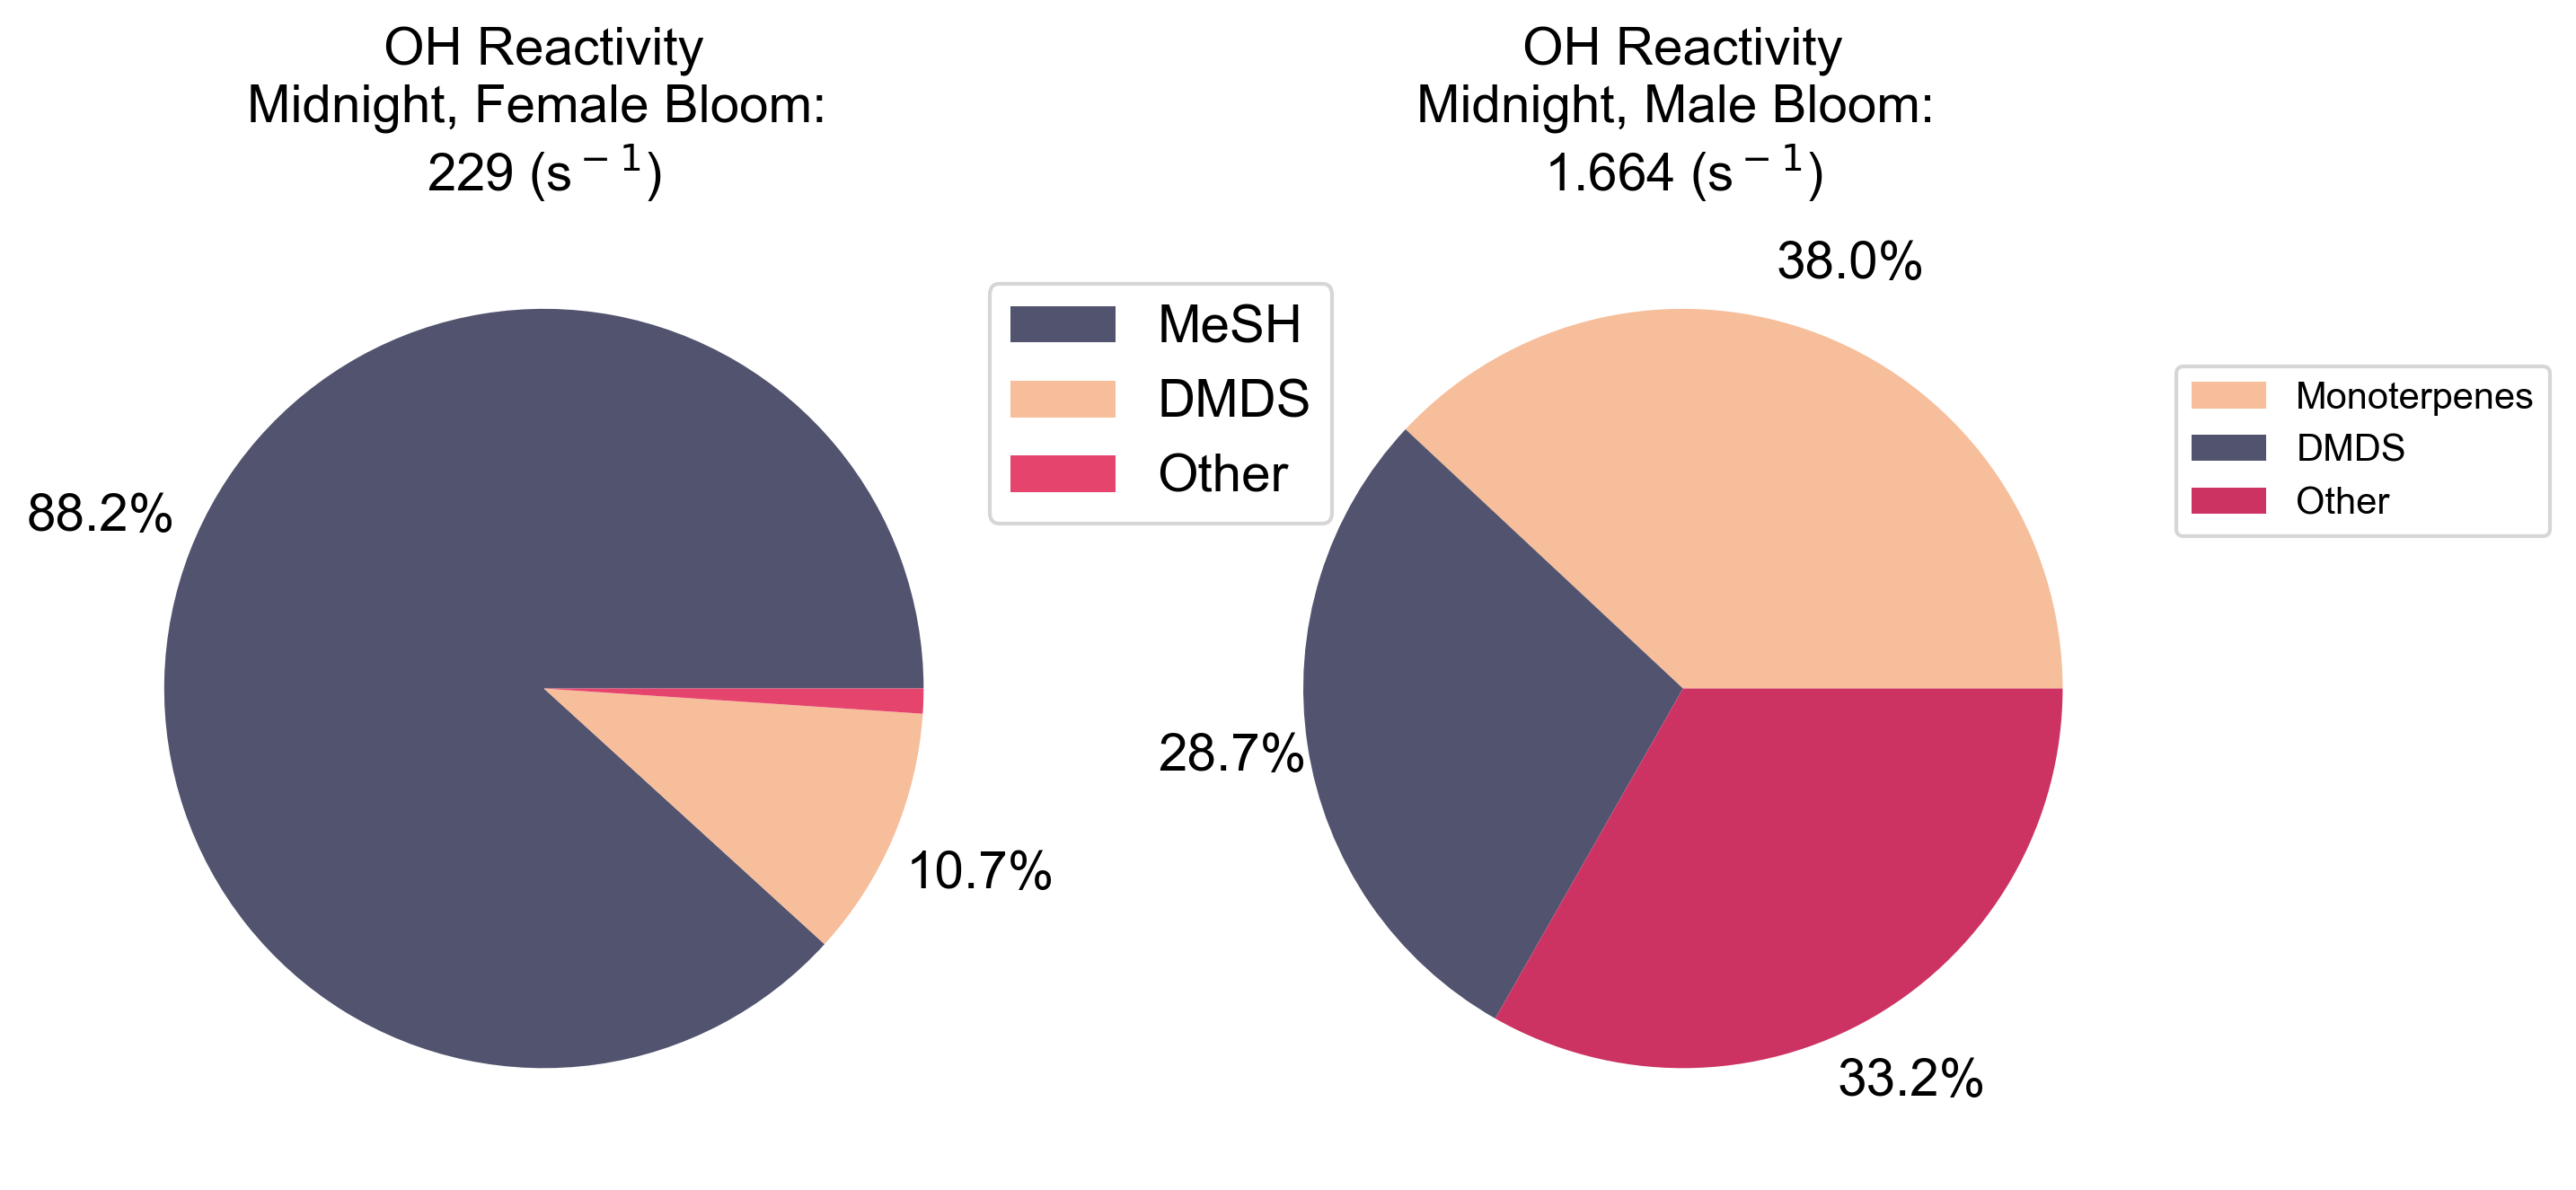

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 12), dpi = 300) # 300 dpi is required for most publications

ax1.pie(top_female_oh_reactivies['oh_reactivity_percent'], 
        labels = no_labels, # labels will label each pie slice 
        pctdistance = 1.25, # setting distance of the percents from the chart
        autopct = lambda pct: '{:1.1f}%'.format(pct) if pct > 5 else '', # setting limits to what percentages are shown
        colors = ['#51536F', '#F6BE9A', '#E5446D'],
      #  hatch = ['', '', '//'], # only want hatch on pink slice to increase visibility of printed images
        textprops = {'fontsize' : 14} 
       )

ax1.legend(loc = 'center',
           bbox_to_anchor = (0.9, 0.2, 0.5, 1.2), # setting distance of legend from plot
           labels = top_female_oh_reactivies['proposed_cmpd_name'],
           fontsize = 14) # settting independent labels for the legend
ax1.set_title('OH Reactivity\nMidnight, Female Bloom: ' + f"\n{top_female_oh_reactivies['oh_reactivity_1/s'].sum():0.0f}" + ' (s$^-$$^1$)', 
              fontsize = 14)

ax2.pie(top_male_oh_reactivies['oh_reactivity_percent'], 
        labels = no_labels, 
        pctdistance = 1.2,
        autopct = lambda pct: '{:1.1f}%'.format(pct) if pct > 5 else '', 
        colors = ['#F6BE9A', '#51536F', '#CC3363'],
        textprops = {'fontsize' : 14} 
       )
ax2.legend(loc = 'center left',
           bbox_to_anchor = (1, 0.25, 0.5, 1), 
           labels = top_male_oh_reactivies['proposed_cmpd_name'])
ax2.set_title('OH Reactivity\nMidnight, Male Bloom: ' + f"\n{top_male_oh_reactivies['oh_reactivity_1/s'].sum():0.3f}" + ' (s$^-$$^1$)', 
    fontsize = 14)

save_path = 'C:\\Users\\rossellr\\OneDrive - Colostate\\Desktop\\CSU\\Research\\Research Projects\\Plants\\CORPSE\\Python\\Fig_Outputs'
fig_name = 'MaleVsFemale_NO3_Reactivity_DiffSizes_' + today + '.png'
fig_save_path = save_path + "/" + fig_name
#plt.savefig(fname = fig_save_path, bbox_inches = 'tight') #keeps legend included when outputting figure

plt.show()#

### Bar Graphs

In [29]:
no_frags_MvF = male_vs_female_totals.copy()
no_frags_MvF.drop(columns = suspect_frag_ions, inplace = True)
totals = no_frags_MvF.sum(axis = 1) # add the total amount for both male and female
totals_ppm = totals / 1000 # converting to ppm to get rid of some trailing zeros
percentage = no_frags_MvF.div(totals, axis = 0).mul(100).round(2) # get percents of total

#graphing_emiss_rates = total_emission_rates_no_frags.transpose() # need cmpds as col names for graphing bar charts

#col_headers = graphing_emiss_rates.columns # getting list of column labels (compound names)

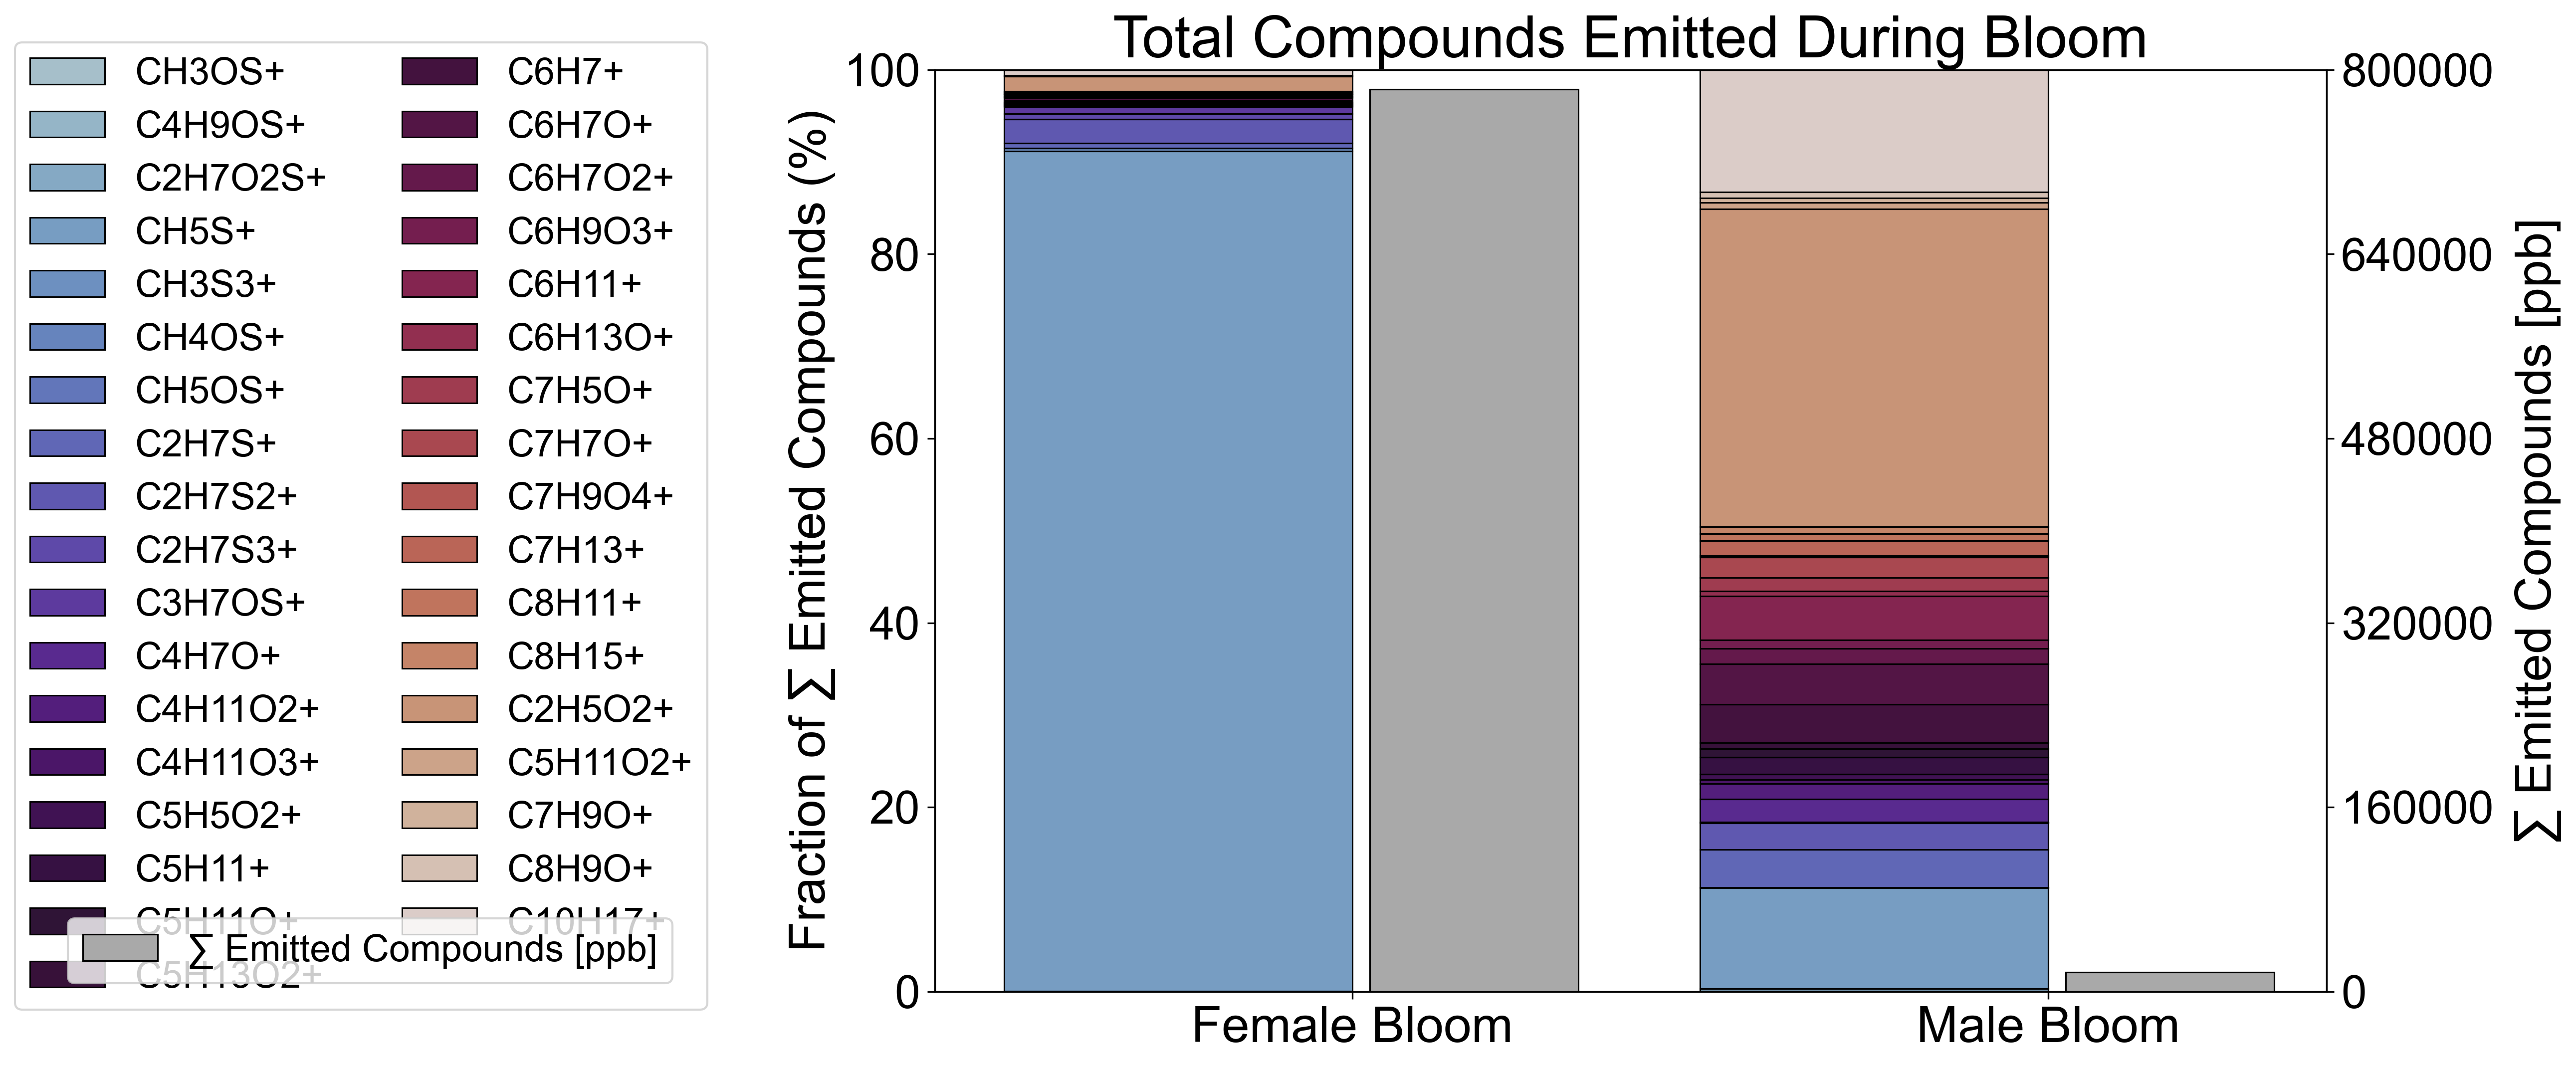

In [30]:

# shifting total bars outside of color bars

# avoiding the extreme ends of the colorbar to get rid of light colors
variable_count = len(percentage.columns)
colormap = plt.get_cmap('twilight')
colors = colors = [colormap(0.1 + (i / (variable_count - 1)) * 0.85) for i in range(variable_count)]

colorbar_width = 0.5 # setting width of bars
totals_width = 0.3

percent_labels = [0, 20, 40, 60, 80, 100] # tick labels
totals_labels = np.linspace(0, 800000, num = 6)
bloom_labels = ['∑ Emitted Compounds [ppb]']

fig, ax = plt.subplots(figsize = (12, 8), dpi = 300)

percentage.plot(kind = 'bar', stacked = True, edgecolor = 'black', linewidth = 0.75, ax = ax,
                     width = colorbar_width, position = 0, color = colors) # give each cmpd a different  color
ax2 = ax.twinx()
ax2 = totals.plot(kind = 'bar', color = 'darkgray', width = totals_width, edgecolor = 'black', linewidth = 0.75,
                  position = -1.75) # shifts bar to the right 
ax2.set_ylabel('∑ Emitted Compounds [ppb]', fontsize = 24, labelpad = 10) # pad = adding some space b/ween axis and axis label
ax.legend(bbox_to_anchor = (-0.15, 1.05), ncol = 2, frameon = True, fontsize = 18) # still need 2 columns in the legend
ax2.legend(loc = 'upper right', labels = bloom_labels, bbox_to_anchor = (-0.175, 0.1), fontsize = 18)
ax.set_ylabel('Fraction of ∑ Emitted Compounds (%)', fontsize = 24)
ax.set_xticks([0.5, 1.5], labels = ['Female Bloom', 'Male Bloom'], rotation = 360, fontsize = 24)
ax.set_ylim([0, 100])
ax2.set_ylim([0, 800000])
ax.set_xlim([-0.1, 1.9])
ax.set_yticks(ticks = percent_labels, labels = percent_labels, fontsize = 22) # have to call label to be able to control fontsize
ax2.set_yticks(ticks = totals_labels, labels = totals_labels, fontsize = 22)

ax2.yaxis.set_major_formatter(FormatStrFormatter('%g')) # %g removes trailing zeros 
#ax2.yaxis.set_major_formatter(ScalarFormatter())
#ax2.ticklabel_format(axis = 'y', style = 'sci', scilimits = (4, 4)) # setting scientific notation on yaxis

plt.title('Total Compounds Emitted During Bloom', fontsize = 28)

save_path = 'C:\\Users\\rossellr\\OneDrive - Colostate\\Desktop\\CSU\\Research\\Plants\\CORPSE\\Python\\Fig_Outputs'
fig_name = 'male_vs_female_no_frags_total_emissions' + today + '.png'

fig_save_path = save_path + "/" + fig_name
#plt.savefig(fname = fig_save_path, bbox_inches = 'tight') #keeps legend included when outputting figure

plt.show()

In [31]:
print(totals)
(totals['total_compound_amt_ppb_female'] - totals['total_compound_amt_ppb_male']) / totals['total_compound_amt_ppb_male']

total_compound_amt_ppb_female    782831.365512
total_compound_amt_ppb_male       16806.379166
dtype: float64


45.57941831481376

<Figure size 3600x4200 with 0 Axes>

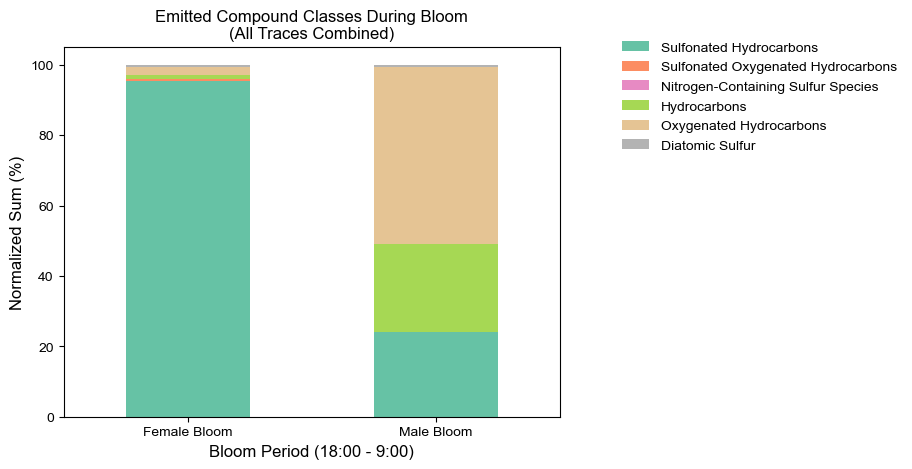

In [32]:
# grouping by compound class

# edit if needed
save_path = 'C:\\Users\\rossellr\\OneDrive - Colostate\\Desktop\\CSU\\Research\\Plants\\CORPSE\\Python\\Fig_Outputs'
fig_name = 'male_vs_female_cmpd_classes' + today + '.png'

copy = male_vs_female_totals.copy()
cmpd_class_sum = []
cmpd_class_sum = pd.DataFrame(cmpd_class_sum)
cmpd_class_sum['s_hc_cmpds'] = (copy['CHS+'] + copy['CH3S+'] + copy['CH3S2+'] + copy['CH3S3+'] + copy['CH5S+'] + copy['CH5S2+'] + copy['C2H5S+'] + 
                                copy['C2H5S2+'] + copy['C2H6S2+'] + copy['C2H7S+'] + copy['C2H7S2+'] + copy['C2H7S3+'])
cmpd_class_sum['s_oxyg_cmpds'] = (copy['CH3OS+'] + copy['CH4OS+'] + copy['CH5OS+'] + copy['CH7OS+'] + copy['C3H7OS+'] +
                                  copy['C4H9OS+'] + copy['C2H7O2S+'])
cmpd_class_sum['N_S_Cmpd'] = copy['CH6N2OS+']
cmpd_class_sum['HC_Cmpds'] = (copy['C5H11+'] + copy['C6H7+'] + copy['C6H11+'] + copy['C7H13+'] + copy['C8H11+'] + copy['C8H15+'] + 
                             copy['C10H17+'])
cmpd_class_sum['OHC_Cmpds'] = (copy['CH5O3+'] + copy['C4H7O+'] + copy['C4H11O2+'] + copy['C4H11O3+'] + copy['C5H5O2+'] + copy['C5H11O+'] + 
                               copy['C5H13O2+'] + copy['C6H7O+'] + copy['C6H7O2+'] + copy['C6H9O3+'] + copy['C6H13O+'] + copy['C7H5O+'] +
                               copy['C7H7O+'] + copy['C7H9O4+'] + copy['C7H11O+'] + copy['C2H5O2+'] + copy['C5H11O2+'] + copy['C7H9O+'] + 
                              copy['C8H9O+'])
cmpd_class_sum['S2'] = copy['S2+']


totals = cmpd_class_sum.sum(axis = 1)
percentage = cmpd_class_sum.div(totals, axis = 0).mul(100).round(2)
colors = plt.get_cmap('Set2', 6) # percents of the whole

class_labels = ['Sulfonated Hydrocarbons', 'Sulfonated Oxygenated Hydrocarbons', 'Nitrogen-Containing Sulfur Species', 
                'Hydrocarbons', 'Oxygenated Hydrocarbons', 'Diatomic Sulfur']

fig = plt.figure(figsize = (12, 14), dpi = 300)
ax = percentage.plot(kind = 'bar', stacked = True, color = [colors(i) for i in range(6)])
ax.legend(bbox_to_anchor = (1.1, 1.05),frameon = False, labels = class_labels)
ax.set_ylabel('Normalized Sum (%)', fontsize = 12)
ax.set_xlabel('Bloom Period (18:00 - 9:00)', fontsize = 12)
ax.set_xticklabels(['Female Bloom', 'Male Bloom'], rotation = 360)
plt.title('Emitted Compound Classes During Bloom\n(All Traces Combined)') # \n puts the next text on another line

fig_save_path = save_path + "/" + fig_name
#plt.savefig(fname = fig_save_path, bbox_inches = 'tight') #keeps legend included when outputting figure

plt.show()

### Emission Rates

In [34]:
# need greenhouse air exchange rate and greenhouse volume

greenhouse_vol = 2870 * 12 # value in ft^3
greenhouse_vol = greenhouse_vol / 35.31468482  # converting ft^3 to m^3
 
greenhouse_exch_rate = 81 # units = 1/hour # average of fCO2 experiment on 20240907 (front analyzer only)

In [35]:
# gotta calc emission rates using *average* compound conc, not integrated concs (like in v4)

# finding the avg number density for each compound over each bloom stage:
copy = female_number_den.copy() # no overwriting !
copy.drop(columns = 'datetime_cmpds', inplace = True) # get rid of dt column - can't average it 
data = copy.mean() # take the mean of each column/compound
female_avg_num_den = pd.DataFrame(data = data, columns = ['female_avg_num_den']) # made df
female_avg_num_den.index.name = 'compounds' # name index
copy = male_number_den.copy() # no overwriting !
copy.drop(columns = 'datetime_cmpds', inplace = True) # get rid of dt column - can't average it 
data = copy.mean() # take the mean of each column/compound
male_avg_num_den = pd.DataFrame(data = data, columns = ['male_avg_num_den']) # made df
male_avg_num_den.index.name = 'compounds' # name index

avg_num_den = pd.concat([female_avg_num_den, male_avg_num_den], axis = 1) # combining into 1 df along shared index

# need list of compound names to remove H+ from name
ignore = 'datetime_cmpds'
compound_list = avg_num_den.index # cmpds are index of this df
for col in compound_list:
    if col != ignore:
        formula_names = remove_PTR_Hion(compound_list) # apply forumla to remove additional H+ from PTR formulas

# need molecular weights for each cmpd to calc emission rates
molecular_weights = [] # creating empty list
for x in formula_names: 
    mw = Formula(x).mass # applying Formula formula from MolarMass library
    molecular_weights.append(mw) # creating new list of MW's 
#molecular_weights = pd.DataFrame(data = molecular_weights, columns = ["molecular_weights_g_mol"])

# converting molc/cm3 into g/m3
g_m3_avgs = avg_num_den / avo_constant # converting from molc/cm3 to mole/cm3 
g_m3_avgs = g_m3_avgs.mul(molecular_weights, axis = 'index') # converting from mole to g
g_m3_avgs = g_m3_avgs.mul(1E6, axis = 'index') # converting from mL to m3 

ER_avgs_g_hour = g_m3_avgs * greenhouse_exch_rate * greenhouse_vol

ER_no_frags_g_hour = ER_avgs_g_hour.transpose() # want cmpds as column names to remove fragments
ER_no_frags_g_hour.drop(columns = suspect_frag_ions, inplace = True) # removing suspected fragments 
ER_no_frags_g_hour = ER_no_frags_g_hour.transpose()
ER_no_frags_g_hour.rename(columns = {'female_avg_num_den' : 'female_g_hour', 'male_avg_num_den' : 'male_g_hour'}, inplace = True)

#print(ER_no_frags_g_hour)


In [36]:
# checking number density vs ppb calcs

copy = female_ts.copy()
copy.drop(columns = 'datetime', inplace = True)
data = copy.mean() # take the mean of each column/compound
female_avg_ppb = pd.DataFrame(data = data, columns = ['female_avg_ppb']) # made df
female_avg_ppb.index.name = 'compounds' # name index
copy = male_ts.copy()
copy.drop(columns = 'datetime', inplace = True)
data = copy.mean() # take the mean of each column/compound
male_avg_ppb = pd.DataFrame(data = data, columns = ['male_avg_ppb']) # made df
male_avg_ppb.index.name = 'compounds' # name index

avg_ppb = pd.concat([female_avg_ppb, male_avg_ppb], axis = 1)

# need list of compound names to remove H+ from name
compound_list = avg_ppb.index # cmpds are index of this df
for col in compound_list:
    if col != ignore:
        formula_names = remove_PTR_Hion(compound_list) # apply forumla to remove additional H+ from PTR formulas
# need molecular weights for each cmpd to calc emission rates
molecular_weights = [] # creating empty list
for x in formula_names: 
    mw = Formula(x).mass # applying Formula formula from MolarMass library
    molecular_weights.append(mw) # creating new list of MW's 

test = avg_ppb * 1E-9 # converting from ppb to mole x / mole air 
test1 = test.mul(molecular_weights, axis = 'index') # converting from mole x to g x
L_air = (1 * 0.08206 * 293) / 0.8
test2 = test1.div(L_air, axis = 'index') # converting from mole air to L air
test3 = test2 * 1000 * greenhouse_exch_rate * greenhouse_vol # converting from L to m3 and then to g/hour

test4 = test3.transpose() # want cmpds as column names to remove fragments
test4.drop(columns = suspect_frag_ions, inplace = True) # removing suspected fragments 
using_avg_ppb_g_hour = test4.transpose()

#print(using_avg_ppb_g_hour)



In [37]:
# calculating gS totals for male and female blooms

pd.options.mode.chained_assignment = None  # default='warn' # getting weird error message when trying to rename columns as seen below
copy = ER_no_frags_g_hour.copy() # no overwriting
mask = copy.index.str.contains('S', case = False, na = False) # only looking for compounds with sulfur
bloom_totals_sulfur = copy[mask] # applying a boolean mask
bloom_totals_sulfur.rename(columns = {'female_g_hour': 'female_totalg_hour', 'male_g_hour' : 'male_totalg_hour'}, 
                          inplace = True) # renaming columns to reflect variables better

# need molar ratio of sulfur : compound
def num_sulfurs(sulfur_cmpds_list): # define function
    s_molar_ratio_list = []
    for x in sulfur_cmpds_list:
        counts = parse_formula(x) # function to get chem formulas
        num_s = counts.get('S', 0)
        if num_s == 1: 
            s_weight = 1
        if num_s == 2: # calc mole ratios
            s_weight = 2
        if num_s == 3:
            s_weight = 3
        s_molar_ratio_list.append((s_weight))
    s_molar_ratio = pd.DataFrame(s_molar_ratio_list, columns = ['s_molar_ratio'])
    return s_molar_ratio # get list

sulfur_cmpds_list = bloom_totals_sulfur.index # gettting list of cmpds 
s_molar_ratios = num_sulfurs(sulfur_cmpds_list) # applying function to cmpd lst

# need compound molecular weights for conversion
molecular_weights = [] # creating empty list
for x in sulfur_cmpds_list: 
    mw = Formula(x).mass # applying Formula formula from MolarMass library
    molecular_weights.append(mw) # creating new list of MW's

s_molar_ratios['molecular_weights'] = molecular_weights # adding to molar ratio df
s_molar_ratios.set_index(sulfur_cmpds_list, inplace = True) # re-indexing to concat with bloom emissions df

sulfur = Formula('S').mass # storing atmomic mass of S

bloom_totals_sulfur = pd.concat([bloom_totals_sulfur, s_molar_ratios], axis = 1) # concatting dfs
bloom_totals_sulfur['gS_female_hour'] = bloom_totals_sulfur['female_totalg_hour'] / bloom_totals_sulfur['molecular_weights'] * bloom_totals_sulfur['s_molar_ratio'] * sulfur
bloom_totals_sulfur['gS_male_hour'] = bloom_totals_sulfur['male_totalg_hour'] / bloom_totals_sulfur['molecular_weights'] * bloom_totals_sulfur['s_molar_ratio'] * sulfur

gS_FvM = bloom_totals_sulfur[['gS_female_hour', 'gS_male_hour']].copy()
total_gS = gS_FvM.sum()

#print(gS_FvM)
#print(gS_FvM.sum())

bloom_totals_sulfur.loc['CH5S+']

female_totalg_hour    18.489154
male_totalg_hour       0.046606
s_molar_ratio          1.000000
molecular_weights     49.114696
gS_female_hour        12.070746
gS_male_hour           0.030427
Name: CH5S+, dtype: float64

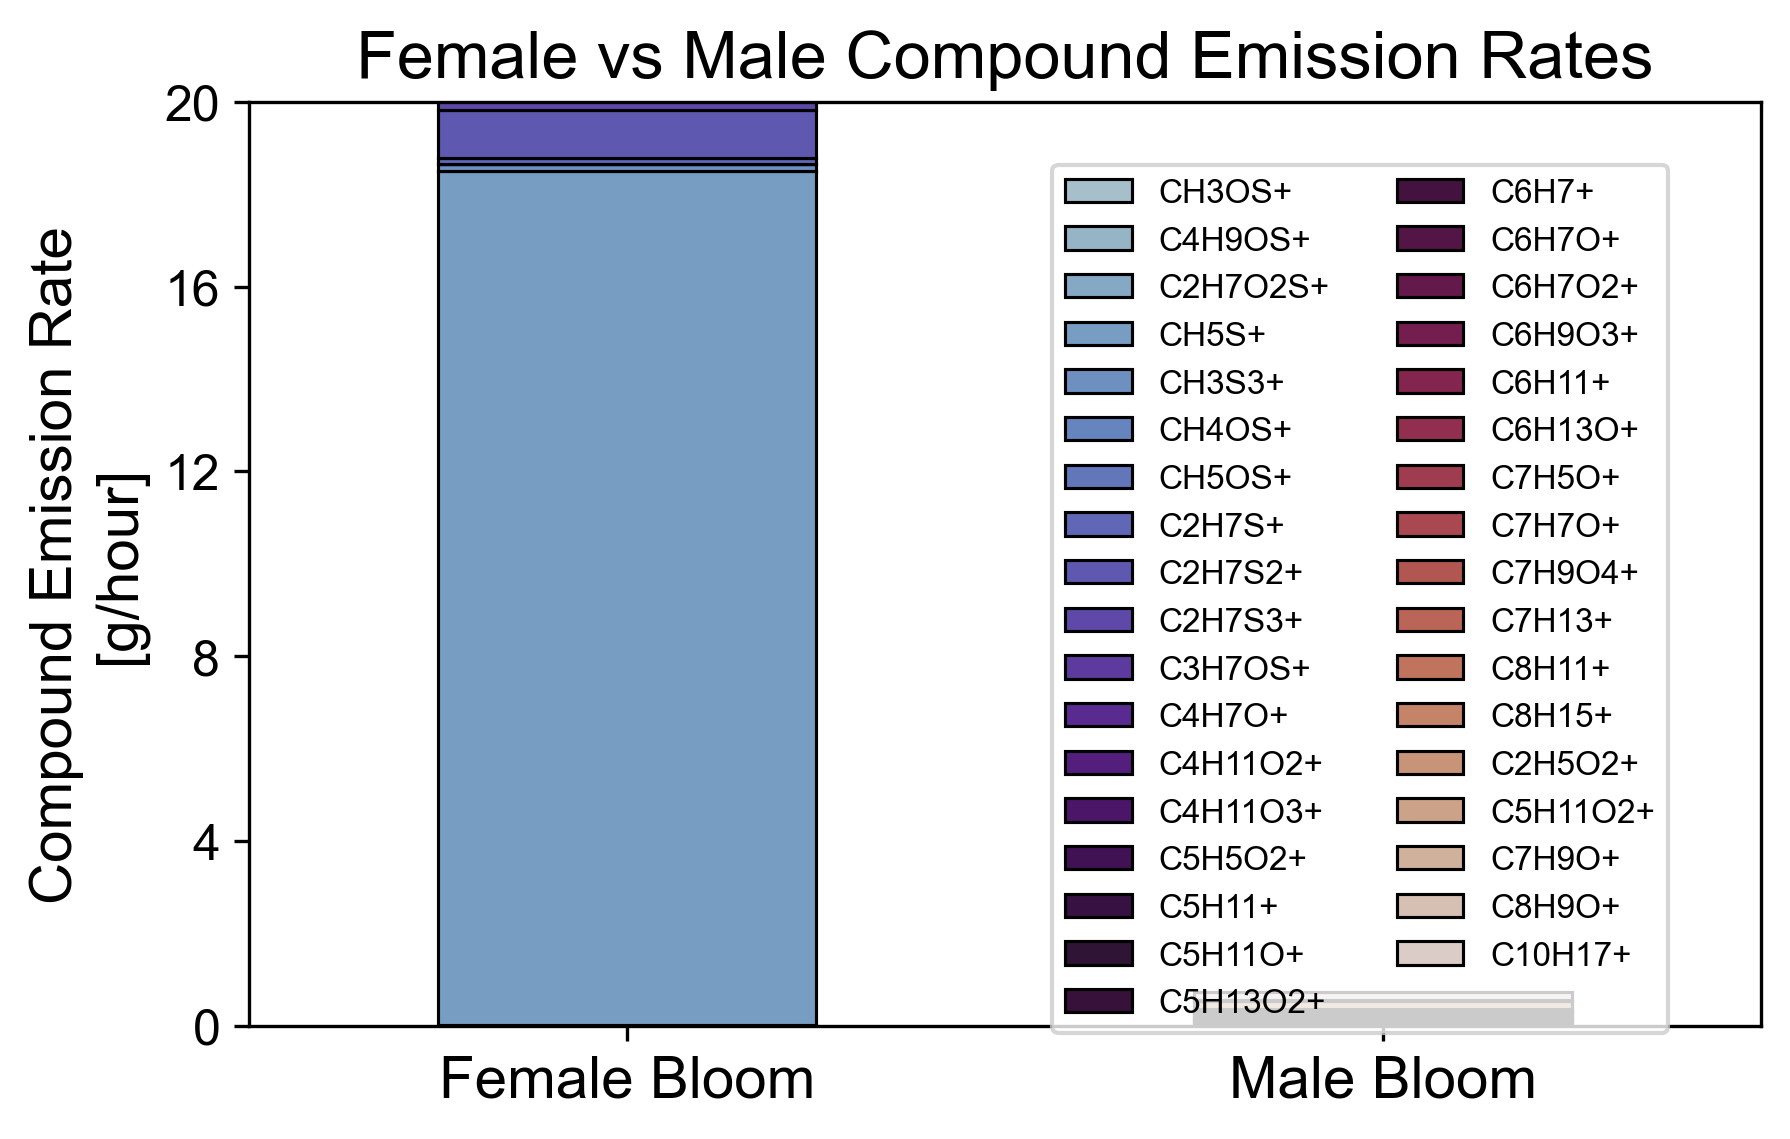

In [38]:
# 2 column version

graphing_emiss_rates = ER_no_frags_g_hour.transpose() # need cmpds as col names for graphing 
# avoiding the extreme ends of the colorbar to get rid of light colors
variable_count = len(graphing_emiss_rates.columns)
colormap = plt.get_cmap('twilight')
colors = colors = [colormap(0.1 + (i / (variable_count - 1)) * 0.85) for i in range(variable_count)]

yaxis_labels = np.linspace(0, 20, num = 6)

fig, ax = plt.subplots(figsize = (6.5, 4), dpi = 300)  

graphing_emiss_rates.plot(kind = 'bar', stacked = True, edgecolor = 'black', linewidth = 0.75, ax = ax,
                               color = colors) # give each cmpd a different  color
ax.set_ylim([0, 20])
ax.legend(loc = 'upper right', bbox_to_anchor = (.95, .95), ncol = 2, frameon = True,  fontsize = 8) # still need 2 columns in the legend
ax.set_ylabel('Compound Emission Rate\n[g/hour]', fontsize = 14)
ax.set_xticklabels(['Female Bloom', 'Male Bloom'], rotation = 360, fontsize = 14)
ax.set_yticks(ticks = yaxis_labels, labels = yaxis_labels, fontsize = 12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g')) # %g removes trailing zeros 

plt.title('Female vs Male Compound Emission Rates', fontsize = 16)

save_path = 'C:\\Users\\rossellr\\OneDrive - Colostate\\Desktop\\CSU\\Research\\Plants\\CORPSE\\Python\\Fig_Outputs'
fig_name = 'FvM_emission_rates_no_frags_linear' + today + '.png'

fig_save_path = save_path + "/" + fig_name
#plt.savefig(fname = fig_save_path, bbox_inches = 'tight') #keeps legend included when outputting figure

plt.show()

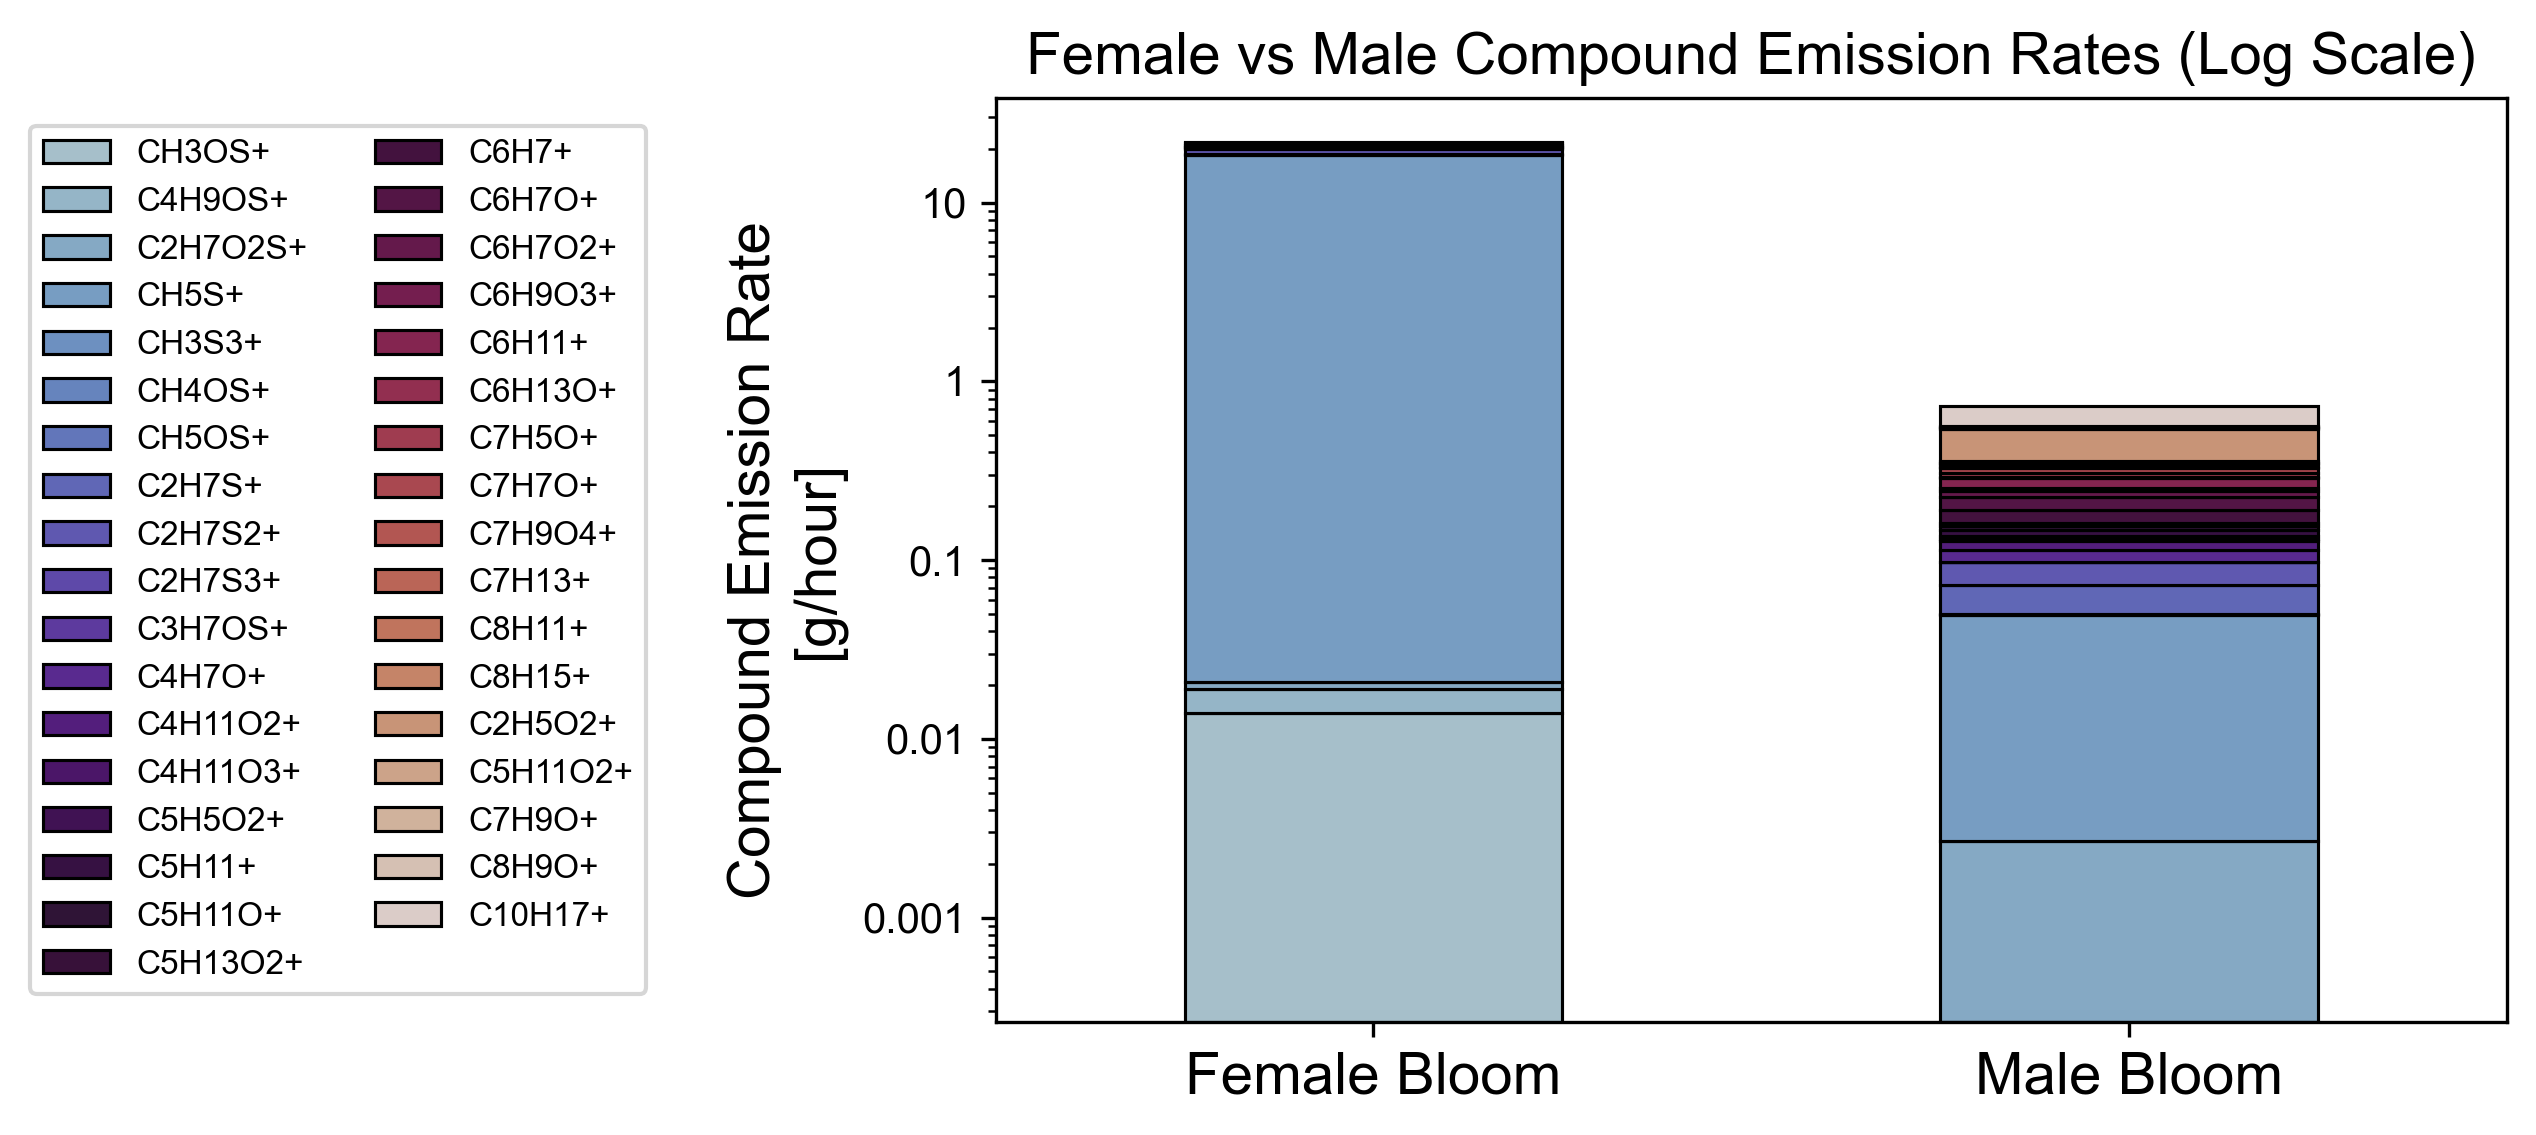

In [39]:
# 2 log scale

graphing_emiss_rates = ER_no_frags_g_hour.transpose() # need cmpds as col names for graphing 
# avoiding the extreme ends of the colorbar to get rid of light colors
variable_count = len(graphing_emiss_rates.columns)
colormap = plt.get_cmap('twilight')
colors = colors = [colormap(0.1 + (i / (variable_count - 1)) * 0.85) for i in range(variable_count)]

yaxis_labels = np.linspace(0, 20, num = 6)

fig, ax = plt.subplots(figsize = (6.5, 4), dpi = 300)  

graphing_emiss_rates.plot(kind = 'bar', stacked = True, edgecolor = 'black', linewidth = 0.75, ax = ax,
                               color = colors) # give each cmpd a different  color
ax.set_yscale('log')
ax.legend(loc = 'center left', bbox_to_anchor = (-.65, .5), ncol = 2, frameon = True,  fontsize = 8) # still need 2 columns in the legend
ax.set_ylabel('Compound Emission Rate\n[g/hour]', fontsize = 14)
ax.set_xticklabels(['Female Bloom', 'Male Bloom'], rotation = 360, fontsize = 14)
#ax.set_yticks(ticks = yaxis_labels, labels = yaxis_labels, fontsize = 12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g')) # %g removes trailing zeros 

plt.title('Female vs Male Compound Emission Rates (Log Scale)', fontsize = 14)

save_path = 'C:\\Users\\rossellr\\OneDrive - Colostate\\Desktop\\CSU\\Research\\Plants\\CORPSE\\Python\\Fig_Outputs'
fig_name = 'FvM_emission_rates_no_frags_log' + today + '.png'

fig_save_path = save_path + "/" + fig_name
#plt.savefig(fname = fig_save_path, bbox_inches = 'tight') #keeps legend included when outputting figure

plt.show()

In [40]:
print(graphing_emiss_rates['CH5S+'])

female_g_hour    18.489154
male_g_hour       0.046606
Name: CH5S+, dtype: float64


### Comparing PTR  to GC data

In [42]:
# averaging the CO2 data to the GC time blocks to get average temp and RH data

co2_ts_copy = co2_ts.copy() # no overwriting !
gc_samp_copy = gc_avg_ppb.copy()

ignore = 'datetime'
for col in co2_ts_copy.columns:
    if col != ignore: # if column does NOT equal the "ignore" column, than coerce any errors
        co2_ts_copy[col] = pd.to_numeric(co2_ts_copy[col], errors = 'coerce') # ensure data cols are all numeric, ignoring the datetime col

for _, row in gc_samp_copy.iterrows(): # for each row in the df:
    name = row['Sample_ID']
    start_time = row['start_datetime']
    end_time = row['end_datetime']
    df = co2_ts_copy[(co2_ts_copy['datetime'] >= start_time)  & (co2_ts_copy['datetime'] <= end_time)] # splice based on start and end times
    exec(f"{name} = df") # name the individual dfs based on the sample ID 
   
# list of dfs to apply the stats function too 
list_samp_dfs = [pre_bloom_1_day_11am, pre_bloom_1_day_1pm, bloom_9am, bloom_10am, bloom_12pm,
                bloom_1pm, bloom_3pm, bloom_5pm, post_bloom_9am, post_bloom_11am]
# names for the stats df 
gc_samp_names = gc_samp_copy['Sample_ID']

co2_time_blocks = pd.concat([calc_time_block_stats(df, name) for df, name in zip(list_samp_dfs, gc_samp_names)]) # concat each stats timeblock df
#print(co2_time_blocks)



In [43]:
# averaging the PTR data to the GC time blocks 

corpse_ts_copy = corpse_ts.copy() # no overwriting !
gc_samp_copy = gc_avg_ppb.copy()

ignore = 'datetime'
for col in corpse_ts_copy.columns:
    if col != ignore: # if column does NOT equal the "ignore" column, than coerce any errors
        corpse_ts_copy[col] = pd.to_numeric(corpse_ts_copy[col], errors = 'coerce') # ensure data cols are all numeric, ignoring the datetime col

for _, row in gc_samp_copy.iterrows(): # for each row in the df:
    name = row['Sample_ID']
    start_time = row['start_datetime']
    end_time = row['end_datetime']
    df = corpse_ts_copy[(corpse_ts_copy['datetime'] >= start_time)  & (corpse_ts_copy['datetime'] <= end_time)] # splice based on start and end times
    exec(f"{name} = df") # name the individual dfs based on the sample ID 
   
# list of dfs to apply the stats function too 
list_samp_dfs = [bloom_9am, bloom_10am, bloom_12pm,
                bloom_1pm, bloom_3pm, bloom_5pm, post_bloom_9am, post_bloom_11am]

# names for the stats df 
gc_samp_names = gc_samp_copy['Sample_ID']
gc_samp_names = gc_samp_names[2:] # we don't have PTR data for any of the pre-bloom days

gc_samp_copy = gc_samp_copy[2:]

ptr_time_blocks = pd.concat([calc_time_block_stats(df, name) for df, name in zip(list_samp_dfs, gc_samp_names)]) # concat each stats timeblock df
#print(ptr_time_blocks)
PTR_means = ptr_time_blocks.xs('mean', level = 'stats') # only want the means for plotting purposes
#print(PTR_means.head)
#print(gc_samp_copy.head)

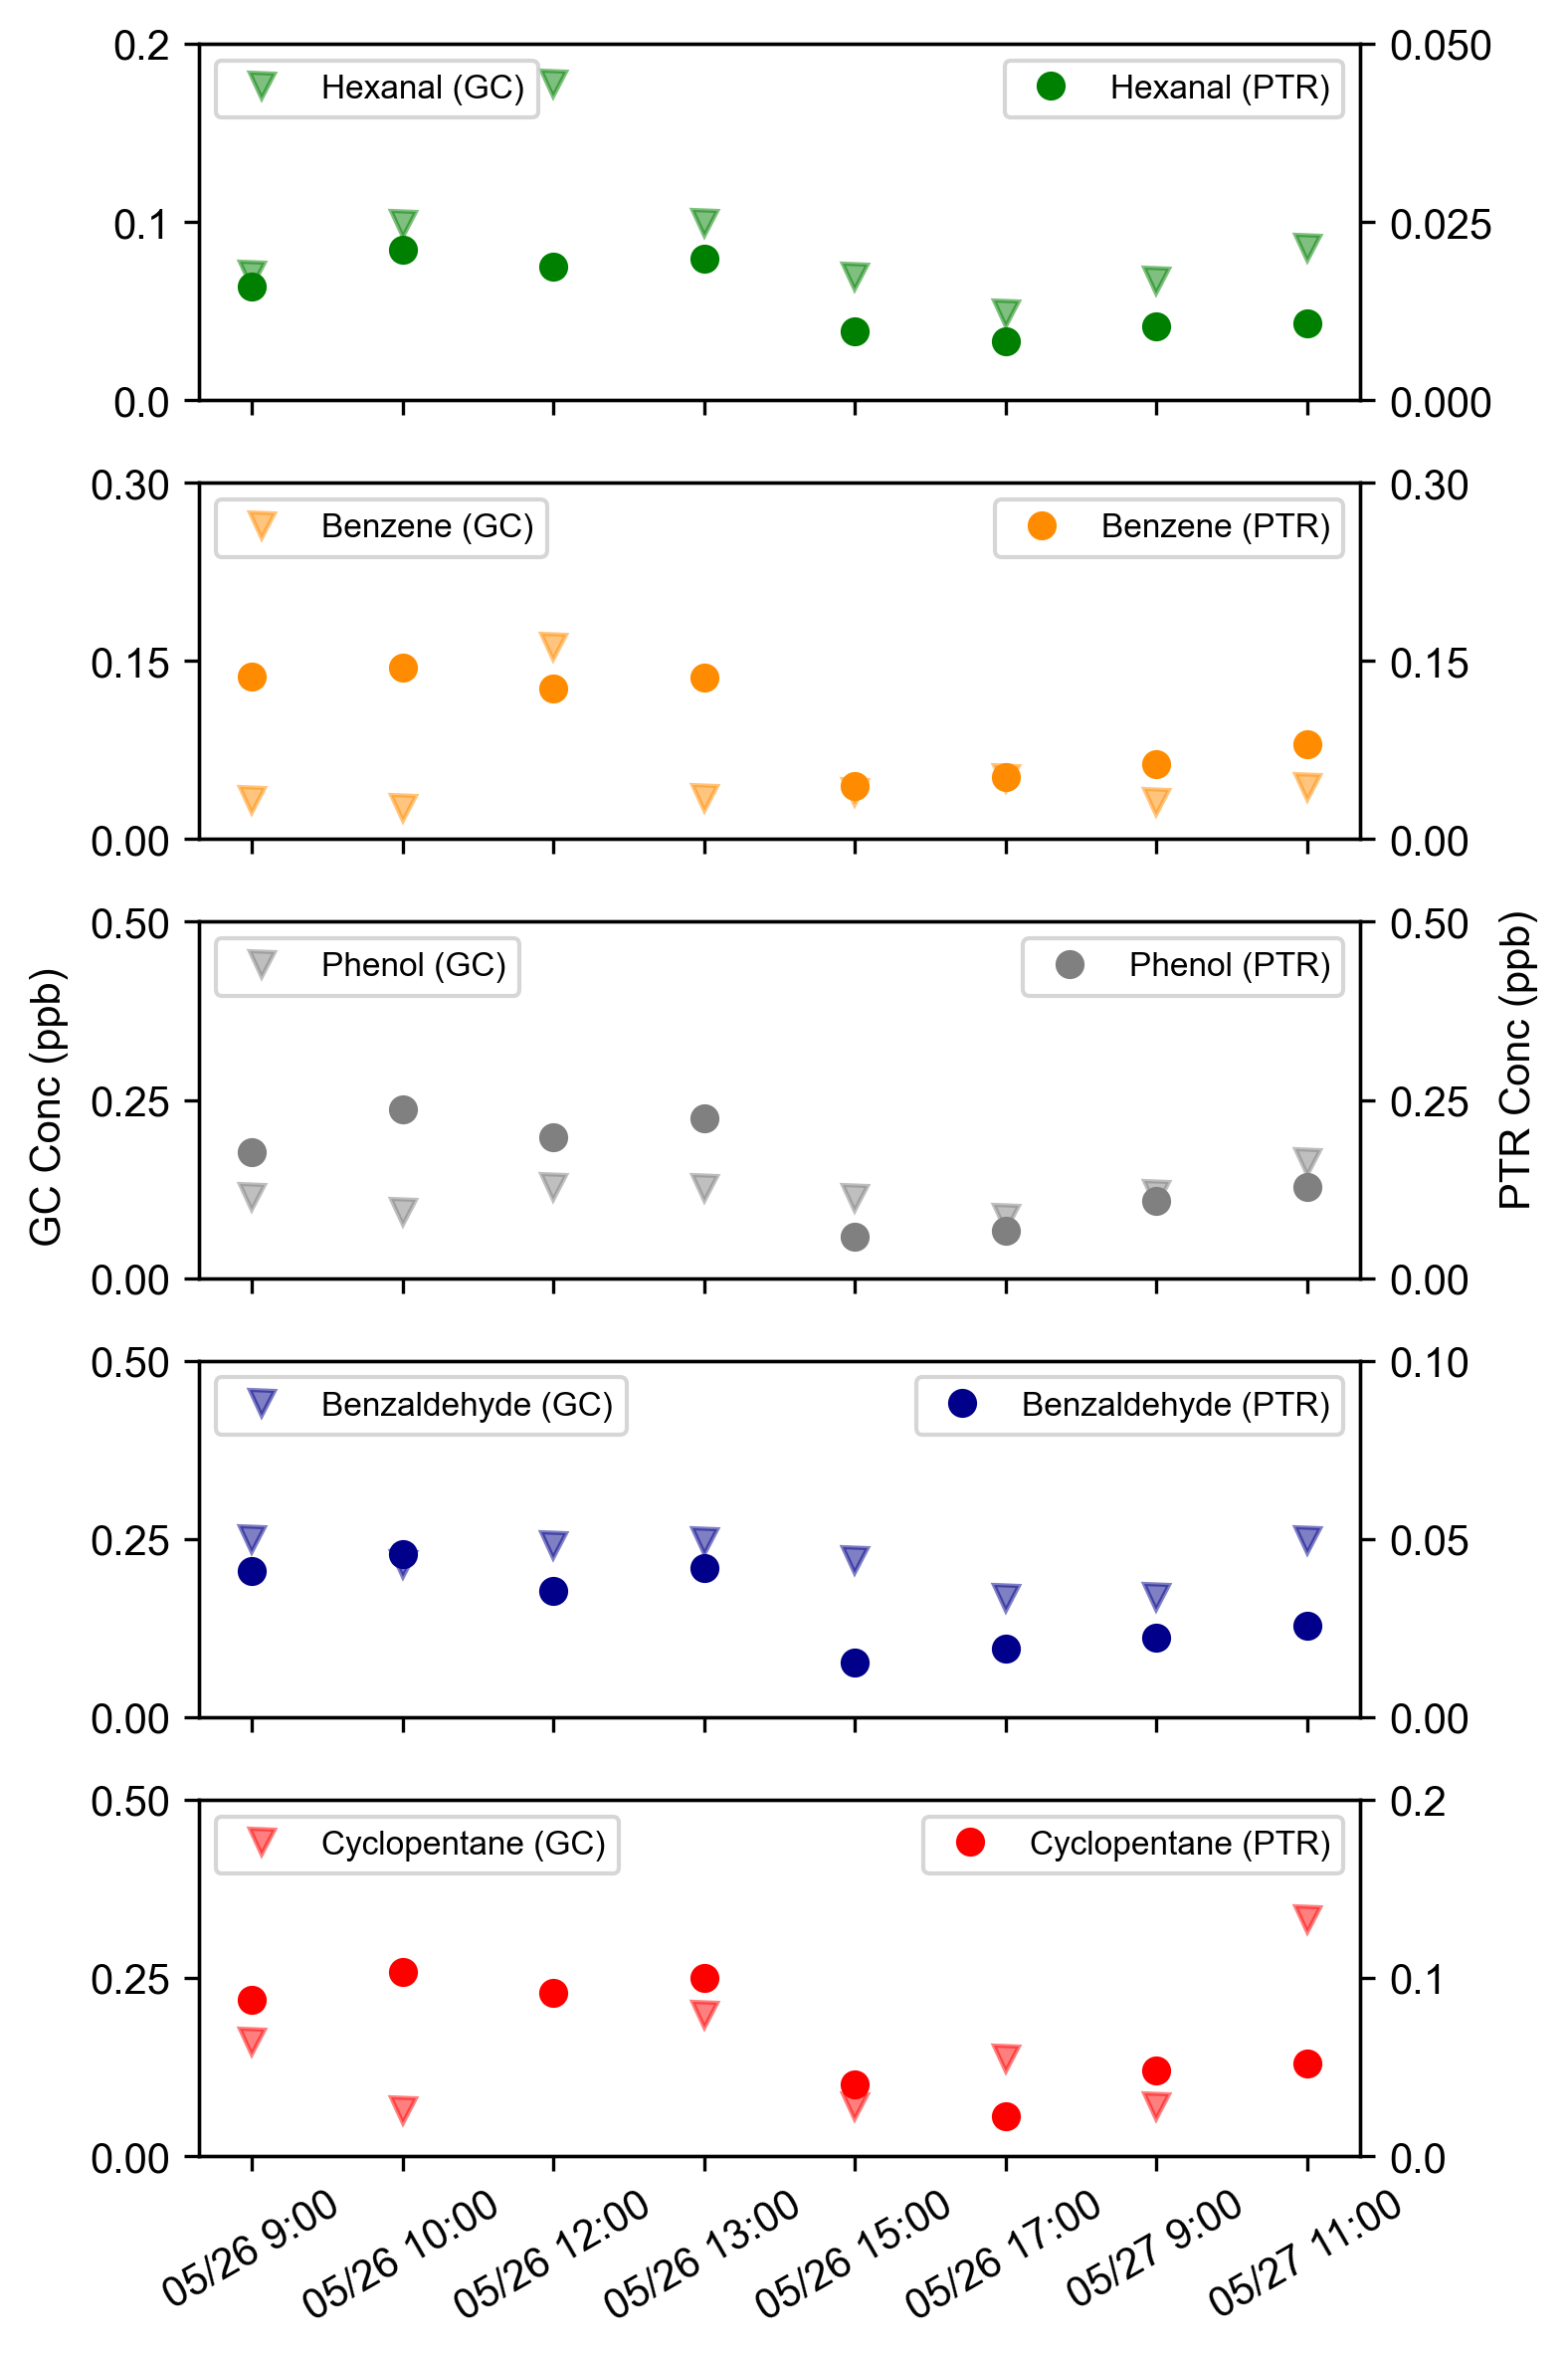

In [44]:
# ptr vs gc comparison: bvocs

labels = ['05/26 9:00', '05/26 10:00', '05/26 12:00', '05/26 13:00', '05/26 15:00', 
         '05/26 17:00', '05/27 9:00', '05/27 11:00']
#labels = pd.to_datetime(labels, format = '%Y-%m-%d %H:%M')

fig, ((ax1), (ax2), (ax3), (ax4), (ax5)) = plt.subplots(ncols = 1, nrows = 5, sharex = True,  dpi = 300, figsize = (5, 8))

ax1.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Hexanal'], label = 'Hexanal (GC)',
         linestyle = '', linewidth = 0.25, marker = 'v', color = 'green', markersize = 6, alpha = 0.5)
ax1.set_yticks(np.linspace(0, 0.2, 3)) # setting ylim and setting number of ticks to 3 
ax11 = ax1.twinx() # create another y axis
ax11.plot(PTR_means.index, PTR_means['C6H13O+'], label = 'Hexanal (PTR)',
         linestyle = '', marker = 'o', color = 'green', markersize = 6)
ax11.set_yticks(np.linspace(0, 0.05, 3))

ax2.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Benzene'], label = 'Benzene (GC)',
         linestyle = '', linewidth = 0.25, marker = 'v', color = 'darkorange', markersize = 6, alpha = 0.5)
ax2.set_yticks(np.linspace(0, 0.3, 3))
ax12 = ax2.twinx() # create another y axis
ax12.plot(PTR_means.index, PTR_means['C6H7+'], label = 'Benzene (PTR)',
         linestyle = '', marker = 'o', color = 'darkorange', markersize = 6)
ax12.set_yticks(np.linspace(0, 0.3, 3))

ax3.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Phenol'], label = 'Phenol (GC)',
         linestyle = '', linewidth = 0.25, marker = 'v', color = 'gray', markersize = 6, alpha = 0.5)
ax3.set_yticks(np.linspace(0, 0.5, 3))
ax13 = ax3.twinx() # create another y axis
ax13.plot(PTR_means.index, PTR_means['C6H7O+'], label = 'Phenol (PTR)',
         linestyle = '', marker = 'o', color = 'gray', markersize = 6)
ax13.set_yticks(np.linspace(0, 0.5, 3))

ax4.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Benzaldehyde'], label = 'Benzaldehyde (GC)',
         linestyle = '', linewidth = 0.25, marker = 'v', color = 'darkblue', markersize = 6, alpha = 0.5)
ax4.set_yticks(np.linspace(0, 0.5, 3))
ax14 = ax4.twinx() # create another y axis
ax14.plot(PTR_means.index, PTR_means['C7H7O+'], label = 'Benzaldehyde (PTR)',
         linestyle = '', marker = 'o', color = 'darkblue', markersize = 6)
ax14.set_yticks(np.linspace(0, 0.1, 3))

ax5.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Cyclopentane'], label = 'Cyclopentane (GC)', alpha = 0.5,
        linestyle = '', linewidth = 0.25, marker = 'v', color = 'red', markersize = 6)
ax5.set_ylim([0, 0.5])
ax5.set_yticks(np.linspace(0, 0.5, 3))
ax15 = ax5.twinx() # create another y axis
ax15.plot(PTR_means.index, PTR_means['C5H11+'], label = 'Cyclopentane (PTR)',
        linestyle = '', marker = 'o', color = 'red', markersize = 6)
ax15.set_yticks(np.linspace(0, 0.2, 3))
ax5.xaxis.set_major_formatter(md.DateFormatter('%D-%m'))
ax5.set_xticks(range(len(labels)), labels = labels, rotation = 30)

fig.text(-0.01, 0.53, 'GC Conc (ppb)', va = 'center', rotation = 'vertical', fontsize = 10) # setting new yaxis labels
fig.text(0.975, 0.55, 'PTR Conc (ppb)', va = 'center', rotation = 'vertical', fontsize = 10)

for ax in [ax1, ax2, ax3, ax4, ax5]: # setting shared parameters between all the subplots
    ax.legend(loc = 'upper left', fontsize = 8)

for ax in [ax11, ax12, ax13, ax14, ax15]:
    ax.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()

save_path = 'C:\\Users\\rossellr\\OneDrive - Colostate\\Desktop\\CSU\\Research\\Research Projects\\Plants\\CORPSE\\Python\\Fig_Outputs'
fig_name = today + '_bvocs_gc_ptr_compre' + '.svg'

fig_save_path = save_path + "/" + fig_name
#plt.savefig(fname = fig_save_path, bbox_inches = 'tight') #keeps legend included when outputting figure

plt.show()
plt.close()


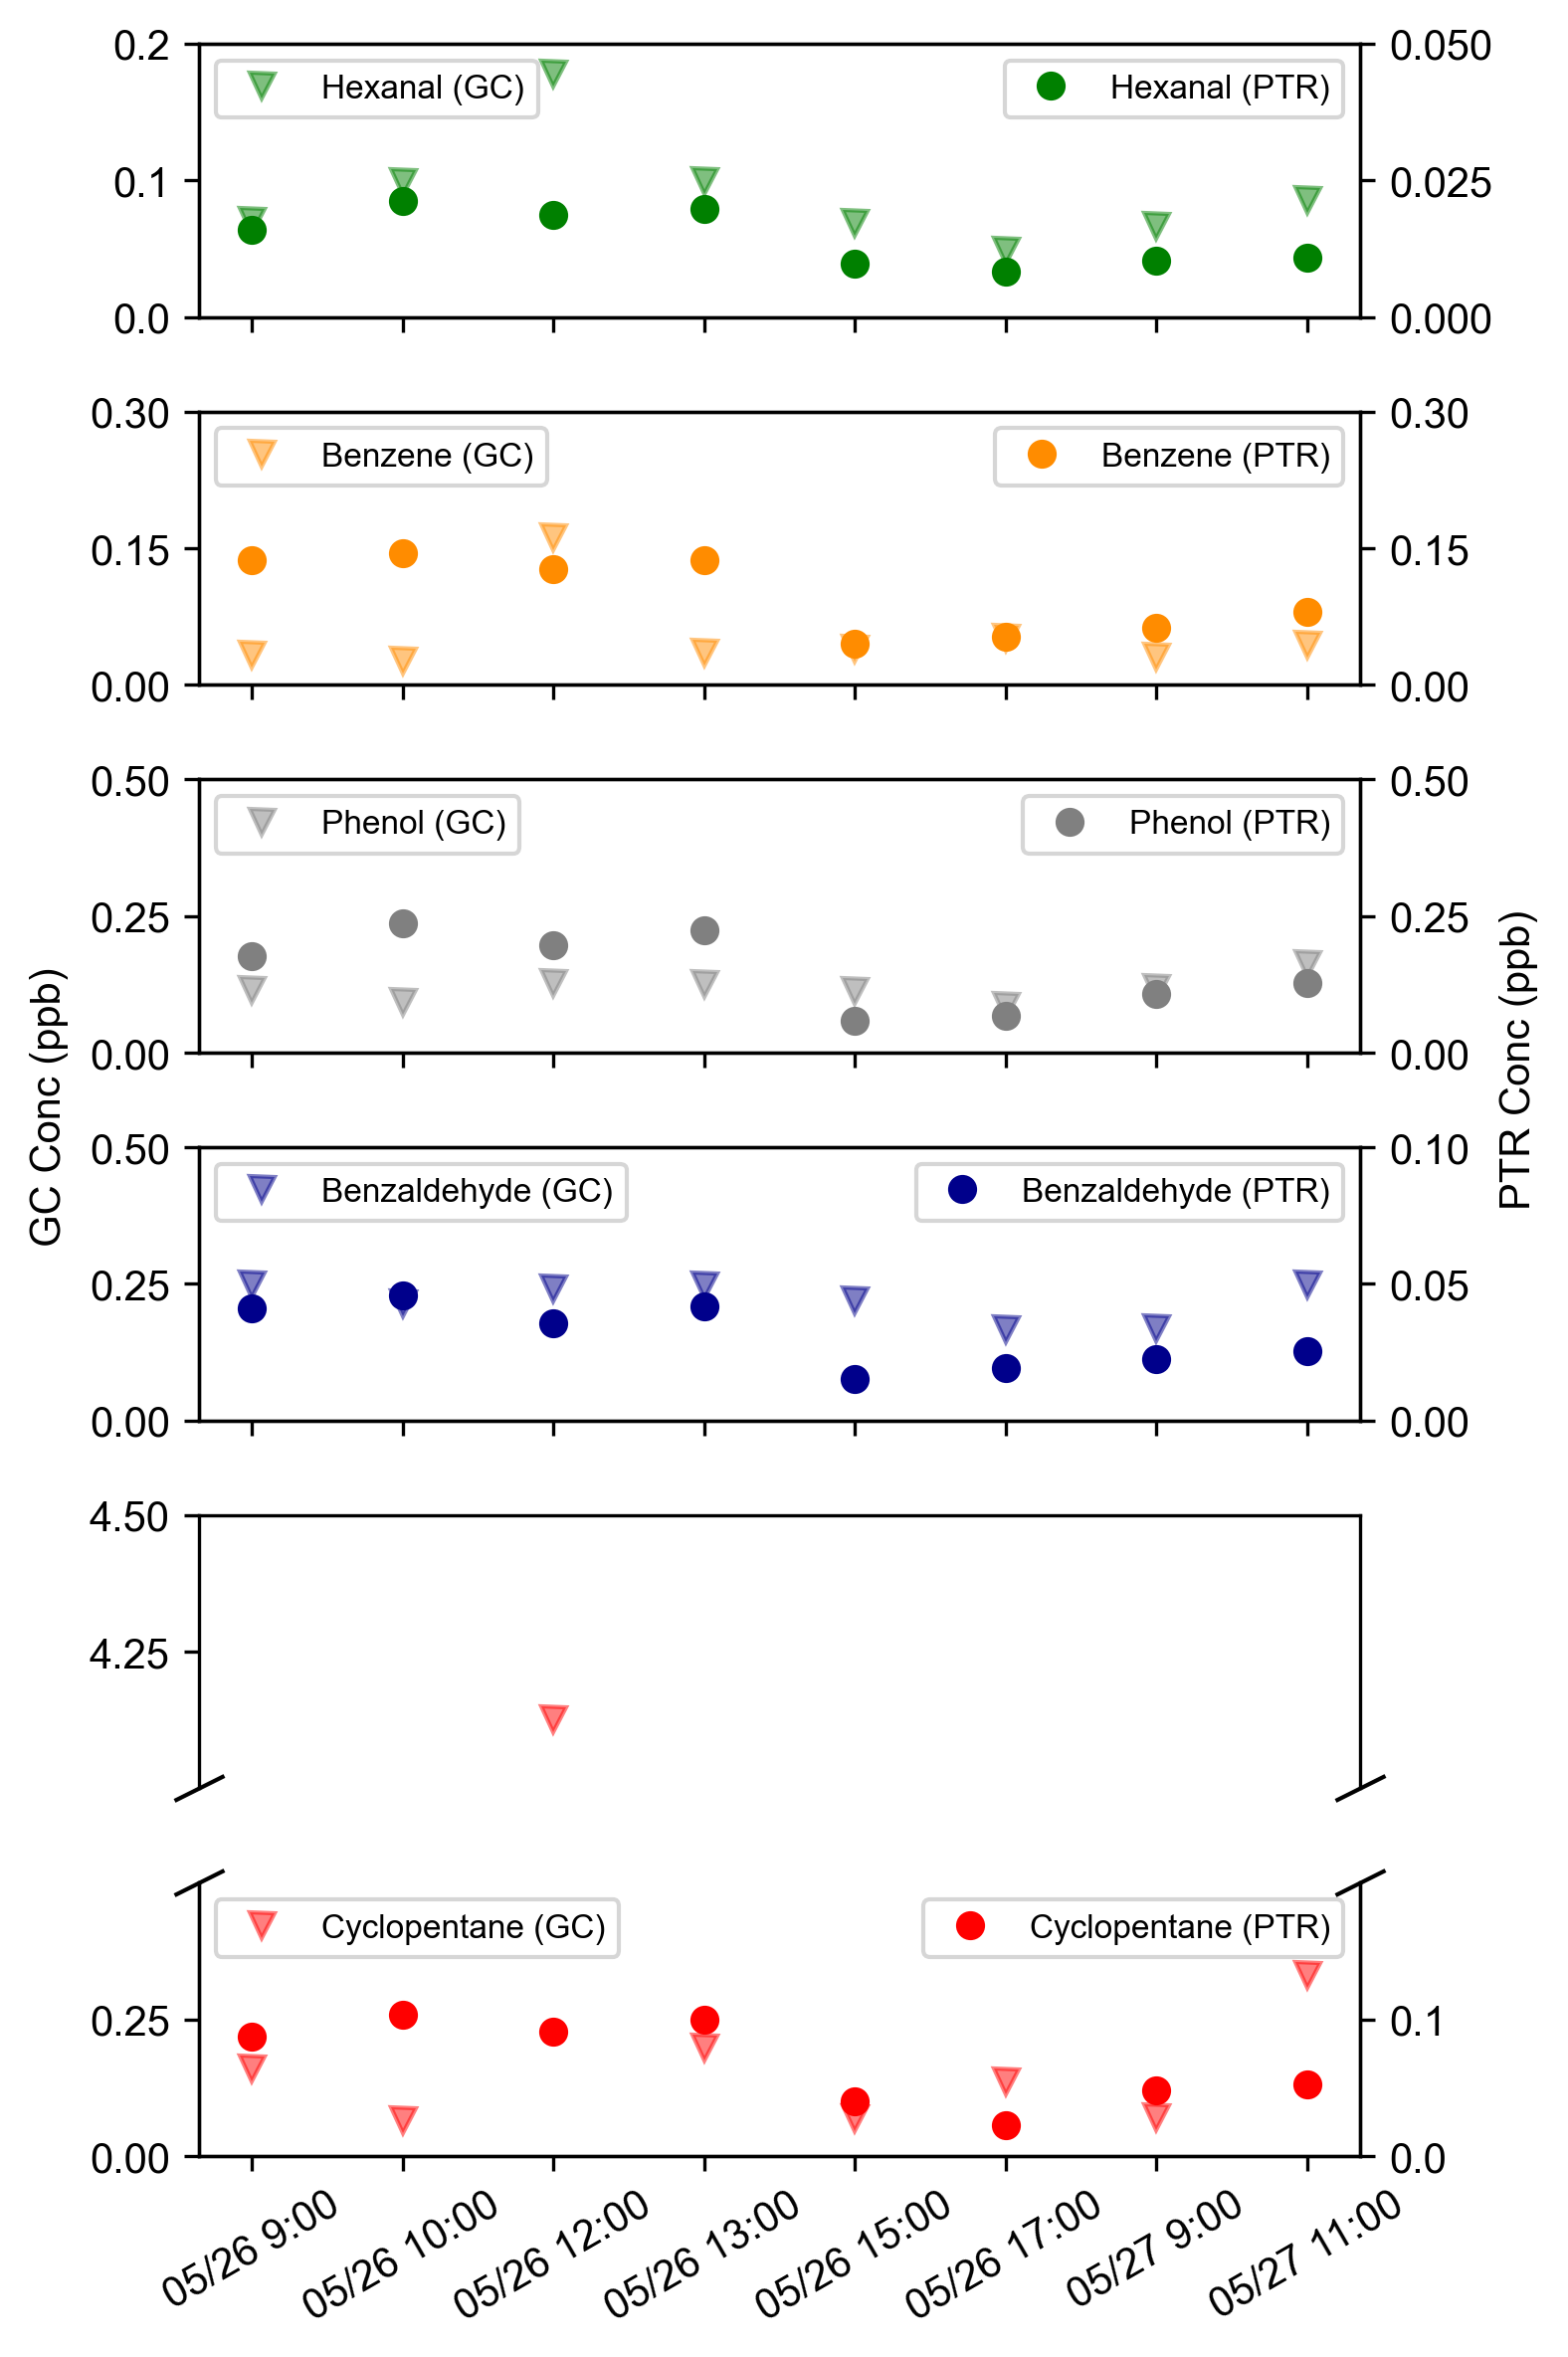

In [179]:
# ptr vs gc comparison: bvocs, splitting up cyclopentane 

labels = ['05/26 9:00', '05/26 10:00', '05/26 12:00', '05/26 13:00', '05/26 15:00', 
         '05/26 17:00', '05/27 9:00', '05/27 11:00']
#labels = pd.to_datetime(labels, format = '%Y-%m-%d %H:%M')

fig, ((ax1), (ax2), (ax3), (ax4), (ax25), (ax5)) = plt.subplots(ncols = 1, nrows = 6, sharex = True,  dpi = 300, figsize = (5, 8))

ax1.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Hexanal'], label = 'Hexanal (GC)',
         linestyle = '', linewidth = 0.25, marker = 'v', color = 'green', markersize = 6, alpha = 0.5)
ax1.set_yticks(np.linspace(0, 0.2, 3)) # setting ylim and setting number of ticks to 3 
ax11 = ax1.twinx() # create another y axis
ax11.plot(PTR_means.index, PTR_means['C6H13O+'], label = 'Hexanal (PTR)',
         linestyle = '', marker = 'o', color = 'green', markersize = 6)
ax11.set_yticks(np.linspace(0, 0.05, 3))

ax2.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Benzene'], label = 'Benzene (GC)',
         linestyle = '', linewidth = 0.25, marker = 'v', color = 'darkorange', markersize = 6, alpha = 0.5)
ax2.set_yticks(np.linspace(0, 0.3, 3))
ax12 = ax2.twinx() # create another y axis
ax12.plot(PTR_means.index, PTR_means['C6H7+'], label = 'Benzene (PTR)',
         linestyle = '', marker = 'o', color = 'darkorange', markersize = 6)
ax12.set_yticks(np.linspace(0, 0.3, 3))

ax3.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Phenol'], label = 'Phenol (GC)',
         linestyle = '', linewidth = 0.25, marker = 'v', color = 'gray', markersize = 6, alpha = 0.5)
ax3.set_yticks(np.linspace(0, 0.5, 3))
ax13 = ax3.twinx() # create another y axis
ax13.plot(PTR_means.index, PTR_means['C6H7O+'], label = 'Phenol (PTR)',
         linestyle = '', marker = 'o', color = 'gray', markersize = 6)
ax13.set_yticks(np.linspace(0, 0.5, 3))

ax4.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Benzaldehyde'], label = 'Benzaldehyde (GC)',
         linestyle = '', linewidth = 0.25, marker = 'v', color = 'darkblue', markersize = 6, alpha = 0.5)
ax4.set_yticks(np.linspace(0, 0.5, 3))
ax14 = ax4.twinx() # create another y axis
ax14.plot(PTR_means.index, PTR_means['C7H7O+'], label = 'Benzaldehyde (PTR)',
         linestyle = '', marker = 'o', color = 'darkblue', markersize = 6)
ax14.set_yticks(np.linspace(0, 0.1, 3))

# top graph of the broken axis for cyclopentance
ax25.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Cyclopentane'], label = 'Cyclopentane (GC)', alpha = 0.5,
        linestyle = '', linewidth = 0.25, marker = 'v', color = 'red', markersize = 6)
ax25.set_ylim([4, 4.5])
ax25.set_yticks(np.linspace(4.25, 4.5, 2))
ax25.xaxis.set_visible(False)
ax25.spines.bottom.set_visible(False)
#ax25.spines.right.set_visible(False)

# bottom graph of the broken axis for cyclopentance
ax5.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Cyclopentane'], label = 'Cyclopentane (GC)', alpha = 0.5,
        linestyle = '', linewidth = 0.25, marker = 'v', color = 'red', markersize = 6)
ax5.set_ylim([0, 0.5])
ax5.set_yticks(np.linspace(0, 0.25, 2))
ax5.spines.top.set_visible(False)
# setting those horizonantal lines
# source code for the split axis: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize = 12,
              linestyle = "none", color = 'k', mec = 'k', mew = 1, clip_on = False)
ax25.plot([0, 1], [0, 0], transform = ax25.transAxes, **kwargs)
ax5.plot([0, 1], [1, 1], transform = ax5.transAxes, **kwargs)


ax15 = ax5.twinx() # create another y axis
ax15.plot(PTR_means.index, PTR_means['C5H11+'], label = 'Cyclopentane (PTR)',
        linestyle = '', marker = 'o', color = 'red', markersize = 6)
ax15.set_ylim([0, 0.2])
ax15.set_yticks(np.linspace(0, 0.1, 2))
ax15.spines.top.set_visible(False)


ax5.xaxis.set_major_formatter(md.DateFormatter('%D-%m'))
ax5.set_xticks(range(len(labels)), labels = labels, rotation = 30)

fig.text(-0.01, 0.53, 'GC Conc (ppb)', va = 'center', rotation = 'vertical', fontsize = 10) # setting new yaxis labels
fig.text(0.975, 0.55, 'PTR Conc (ppb)', va = 'center', rotation = 'vertical', fontsize = 10)

for ax in [ax1, ax2, ax3, ax4, ax5]: # setting shared parameters between all the subplots
    ax.legend(loc = 'upper left', fontsize = 8)

for ax in [ax11, ax12, ax13, ax14, ax15]:
    ax.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()

save_path = 'C:\\Users\\rossellr\\OneDrive - Colostate\\Desktop\\CSU\\Research\\Research Projects\\Plants\\CORPSE\\Python\\Final_Figs'
fig_name = today + '_bvocs_gc_ptr_compre' + '.svg'

fig_save_path = save_path + "/" + fig_name
#plt.savefig(fname = fig_save_path, bbox_inches = 'tight') #keeps legend included when outputting figure

plt.show()
plt.close()


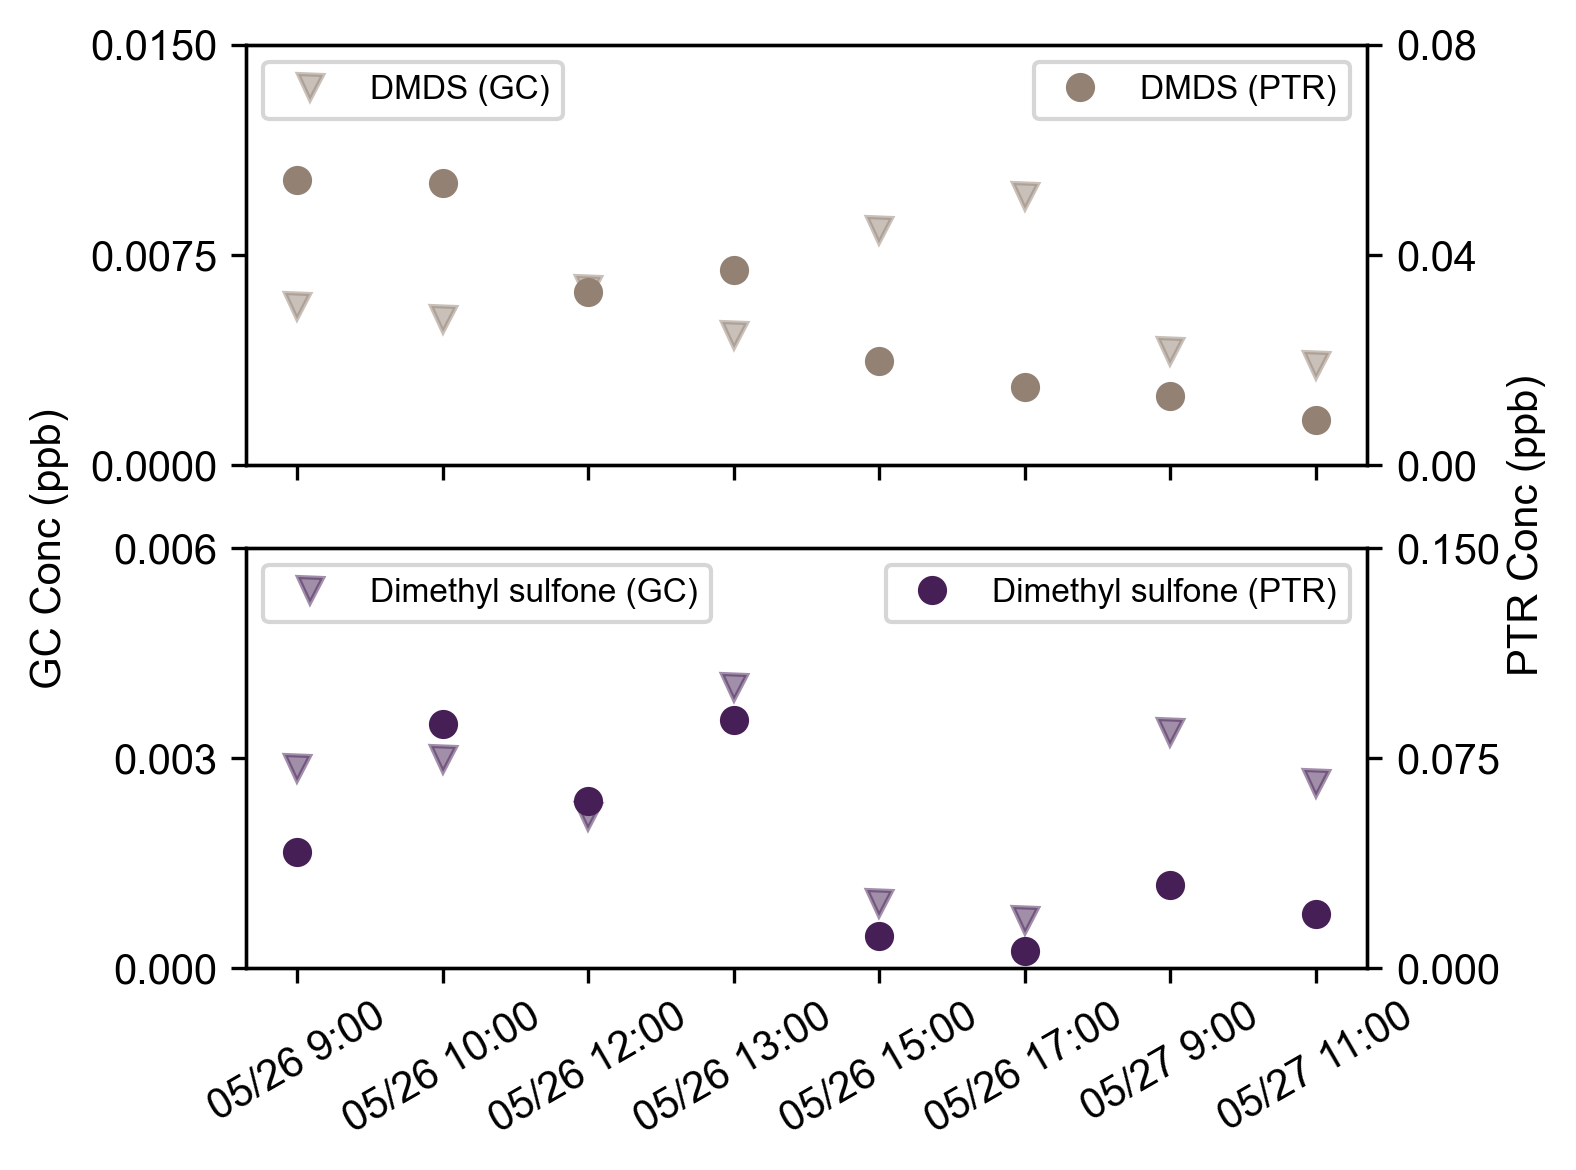

In [45]:
# ptr vs gc data for S cmpds

labels = ['05/26 9:00', '05/26 10:00', '05/26 12:00', '05/26 13:00', '05/26 15:00', 
         '05/26 17:00', '05/27 9:00', '05/27 11:00']
#labels = pd.to_datetime(labels, format = '%Y-%m-%d %H:%M')

fig, ((ax1), (ax2)) = plt.subplots(ncols = 1, nrows = 2, sharex = True,  dpi = 300, figsize = (5, 4))

ax1.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Dimethyl disulfide'], label = 'DMDS (GC)',
         linestyle = '', linewidth = 0.25, marker = 'v', color = '#938274', markersize = 6, alpha = 0.5)
ax1.set_yticks(np.linspace(0, 0.015, 3)) # setting ylim and setting number of ticks to 3 
ax11 = ax1.twinx() # create another y axis
ax11.plot(PTR_means.index, PTR_means['C2H7S2+'], label = 'DMDS (PTR)',
         linestyle = '', marker = 'o', color = '#938274', markersize = 6)
ax11.set_yticks(np.linspace(0, 0.08, 3))

ax2.plot(gc_samp_copy['Sample_ID'], gc_samp_copy['Dimethyl sulfone'], label = 'Dimethyl sulfone (GC)',
         linestyle = '', linewidth = 0.25, marker = 'v', color = '#451F55', markersize = 6, alpha = 0.5)
ax2.set_yticks(np.linspace(0, 0.006, 3)) # setting ylim and setting number of ticks to 3 
ax12 = ax2.twinx() # create another y axis
ax12.plot(PTR_means.index, PTR_means['C2H7O2S+'], label = 'Dimethyl sulfone (PTR)',
         linestyle = '', marker = 'o', color = '#451F55', markersize = 6)
ax12.set_yticks(np.linspace(0, 0.15, 3))

ax2.xaxis.set_major_formatter(md.DateFormatter('%D-%m'))
ax2.set_xticks(range(len(labels)), labels = labels, rotation = 30)

fig.text(-0.01, 0.53, 'GC Conc (ppb)', va = 'center', rotation = 'vertical', fontsize = 10) # setting new yaxis labels
fig.text(0.975, 0.55, 'PTR Conc (ppb)', va = 'center', rotation = 'vertical', fontsize = 10)

for ax in [ax1, ax2, ax3, ax4, ax5]: # setting shared parameters between all the subplots
    ax.legend(loc = 'upper left', fontsize = 8)

for ax in [ax11, ax12, ax13, ax14, ax15]:
    ax.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()

save_path = 'C:\\Users\\rossellr\\OneDrive - Colostate\\Desktop\\CSU\\Research\\Research Projects\\Plants\\CORPSE\\Python\\Fig_Outputs'
fig_name = today + '_sulfur_gc_ptr_compre' + '.svg'

fig_save_path = save_path + "/" + fig_name
#plt.savefig(fname = fig_save_path, bbox_inches = 'tight') #keeps legend included when outputting figure

plt.show()
plt.close()


## Nitrate Exposures

In [47]:
# [VOC reacted away] = [Initial VOC] (molc/cm3) * kvoc-no3 (cm3 / molc s) * [no3] (ppt) * exposure time (s)
# [VOC remaining] = [Initial VOC] - [VOC reacted away]

pristine_no3_conc_ppb = 2 / 1000
polluted_no3_conc_ppb = 15 / 1000
exposure_time_sec = 3600 # 1 hour


In [48]:
# setting up the inital conc df

cmpd_k_no3 = vp_react_emission_concat[['k_no3_298K']].copy() # need all legends to pull from data that won't change based on exposure
copy = male_ts.copy()
male_midnight = copy.loc[(copy['datetime'] >= '2024-05-26 23:55') # using midnight as the reference point again
    & (copy['datetime'] < '2024-05-27 00:05')]
male_midnight = male_midnight.loc[[2104]] # selecting index that is closest to midnight

male_midnight.drop(columns = ['datetime'], inplace = True) # dropping datetime col 
male_midnight = male_midnight[cmpd_names] # only pulling out compounds we have data for
male_midnight = male_midnight.transpose() # want cmpds as row labels
male_midnight.rename(columns = {2104 : 'midnight_ppb'}, inplace = True)
male_midnight = pd.concat([male_midnight, cmpd_k_no3], axis = 1) # combining

cmpd_k_no3 = vp_react_emission_concat[['k_no3_298K']].copy() # rinse and repeat
copy = female_ts.copy()
female_midnight = copy.loc[(copy['datetime'] >= '2024-05-25 23:55')
    & (copy['datetime'] < '2024-05-26 00:05')]
female_midnight = female_midnight.loc[[2075]] 
female_midnight.drop(columns = ['datetime'], inplace = True)
female_midnight = female_midnight[cmpd_names]
female_midnight = female_midnight.transpose() 
female_midnight.rename(columns = {2075 : 'midnight_ppb'}, inplace = True)
female_midnight = pd.concat([female_midnight, cmpd_k_no3], axis = 1)

# calculating exposures for female VOCs at midnight
female_exposures = female_midnight_reactivies[['compounds', 'proposed_cmpd_name', 'female_num_den_midnight', 'no3_reactivity_1/s']].copy() 
female_exposures['pristine_loss_ppb_3hour'] = female_exposures['no3_reactivity_1/s'] * pristine_no3_conc_ppb * (exposure_time_sec * 3) 
female_exposures['polluted_loss_ppb_3hour'] = female_exposures['no3_reactivity_1/s'] * polluted_no3_conc_ppb * (exposure_time_sec * 3) 
female_exposures.set_index('compounds', inplace = True)
female_exposures = pd.concat([female_exposures, female_midnight], axis = 1) # adding in original concentrations
female_exposures.reset_index(inplace = True)
female_exposures.drop([0, 5], inplace = True) # dropping DMTS b/c NaN and dimethyl sulfone b/c data is negative
female_exposures['pristine_remaining_ppb'] = female_exposures['midnight_ppb'] - female_exposures['pristine_loss_ppb_3hour']
female_exposures['polluted_remaining_ppb'] = female_exposures['midnight_ppb'] - female_exposures['polluted_loss_ppb_3hour']
# can't have negative values for the pie charts, so replacing all negatives with zero
female_exposures['pristine_remaining_ppb'] = np.where(female_exposures['pristine_remaining_ppb'] < 0, 0, female_exposures['pristine_remaining_ppb'])
female_exposures['polluted_remaining_ppb'] = np.where(female_exposures['polluted_remaining_ppb'] < 0, 0, female_exposures['polluted_remaining_ppb'])
female_exposures.sort_values(by = ['k_no3_298K'], inplace = True, ascending = False) # sorting by highest reactivity

# rinse and repeat
male_exposures = male_midnight_reactivies[['compounds', 'proposed_cmpd_name', 'male_num_den_midnight', 'no3_reactivity_1/s']].copy()
male_exposures['pristine_loss_ppb_3hour'] = male_exposures['no3_reactivity_1/s'] * pristine_no3_conc_ppb * (exposure_time_sec * 3) # 3 hours
male_exposures['polluted_loss_ppb_3hour'] = male_exposures['no3_reactivity_1/s'] * polluted_no3_conc_ppb * (exposure_time_sec * 3)
male_exposures.set_index('compounds', inplace = True)
male_exposures = pd.concat([male_exposures, male_midnight], axis = 1) 
male_exposures.reset_index(inplace = True)
male_exposures.drop([0, 5], inplace = True) 
male_exposures['pristine_remaining_ppb'] = male_exposures['midnight_ppb'] - male_exposures['pristine_loss_ppb_3hour']
male_exposures['polluted_remaining_ppb'] = male_exposures['midnight_ppb'] - male_exposures['polluted_loss_ppb_3hour']
male_exposures['pristine_remaining_ppb'] = np.where(male_exposures['pristine_remaining_ppb'] < 0, 0, male_exposures['pristine_remaining_ppb'])
male_exposures['polluted_remaining_ppb'] = np.where(male_exposures['polluted_remaining_ppb'] < 0, 0, male_exposures['polluted_remaining_ppb'])
male_exposures.sort_values(by = ['k_no3_298K'], inplace = True, ascending = False)



In [49]:
# setting variables to change add secondary pie charts that are sized by emissions

base_radius = 1 # sizing scale factor for area of plots

female_radius_scale_factor_pristine = mat.sqrt(((female_exposures['pristine_remaining_ppb'].sum())/female_exposures['midnight_ppb'].sum()) / mat.pi) # turning area into radius for sizing
female_radius_scale_factor_polluted = mat.sqrt((female_exposures['polluted_remaining_ppb'].sum()/female_exposures['midnight_ppb'].sum()) / mat.pi)

male_radius_scale_factor_pristine = mat.sqrt(((male_exposures['pristine_remaining_ppb'].sum())/male_exposures['midnight_ppb'].sum()) / mat.pi) # turning area into radius for sizing
male_radius_scale_factor_polluted = mat.sqrt((male_exposures['polluted_remaining_ppb'].sum()/male_exposures['midnight_ppb'].sum()) / mat.pi)



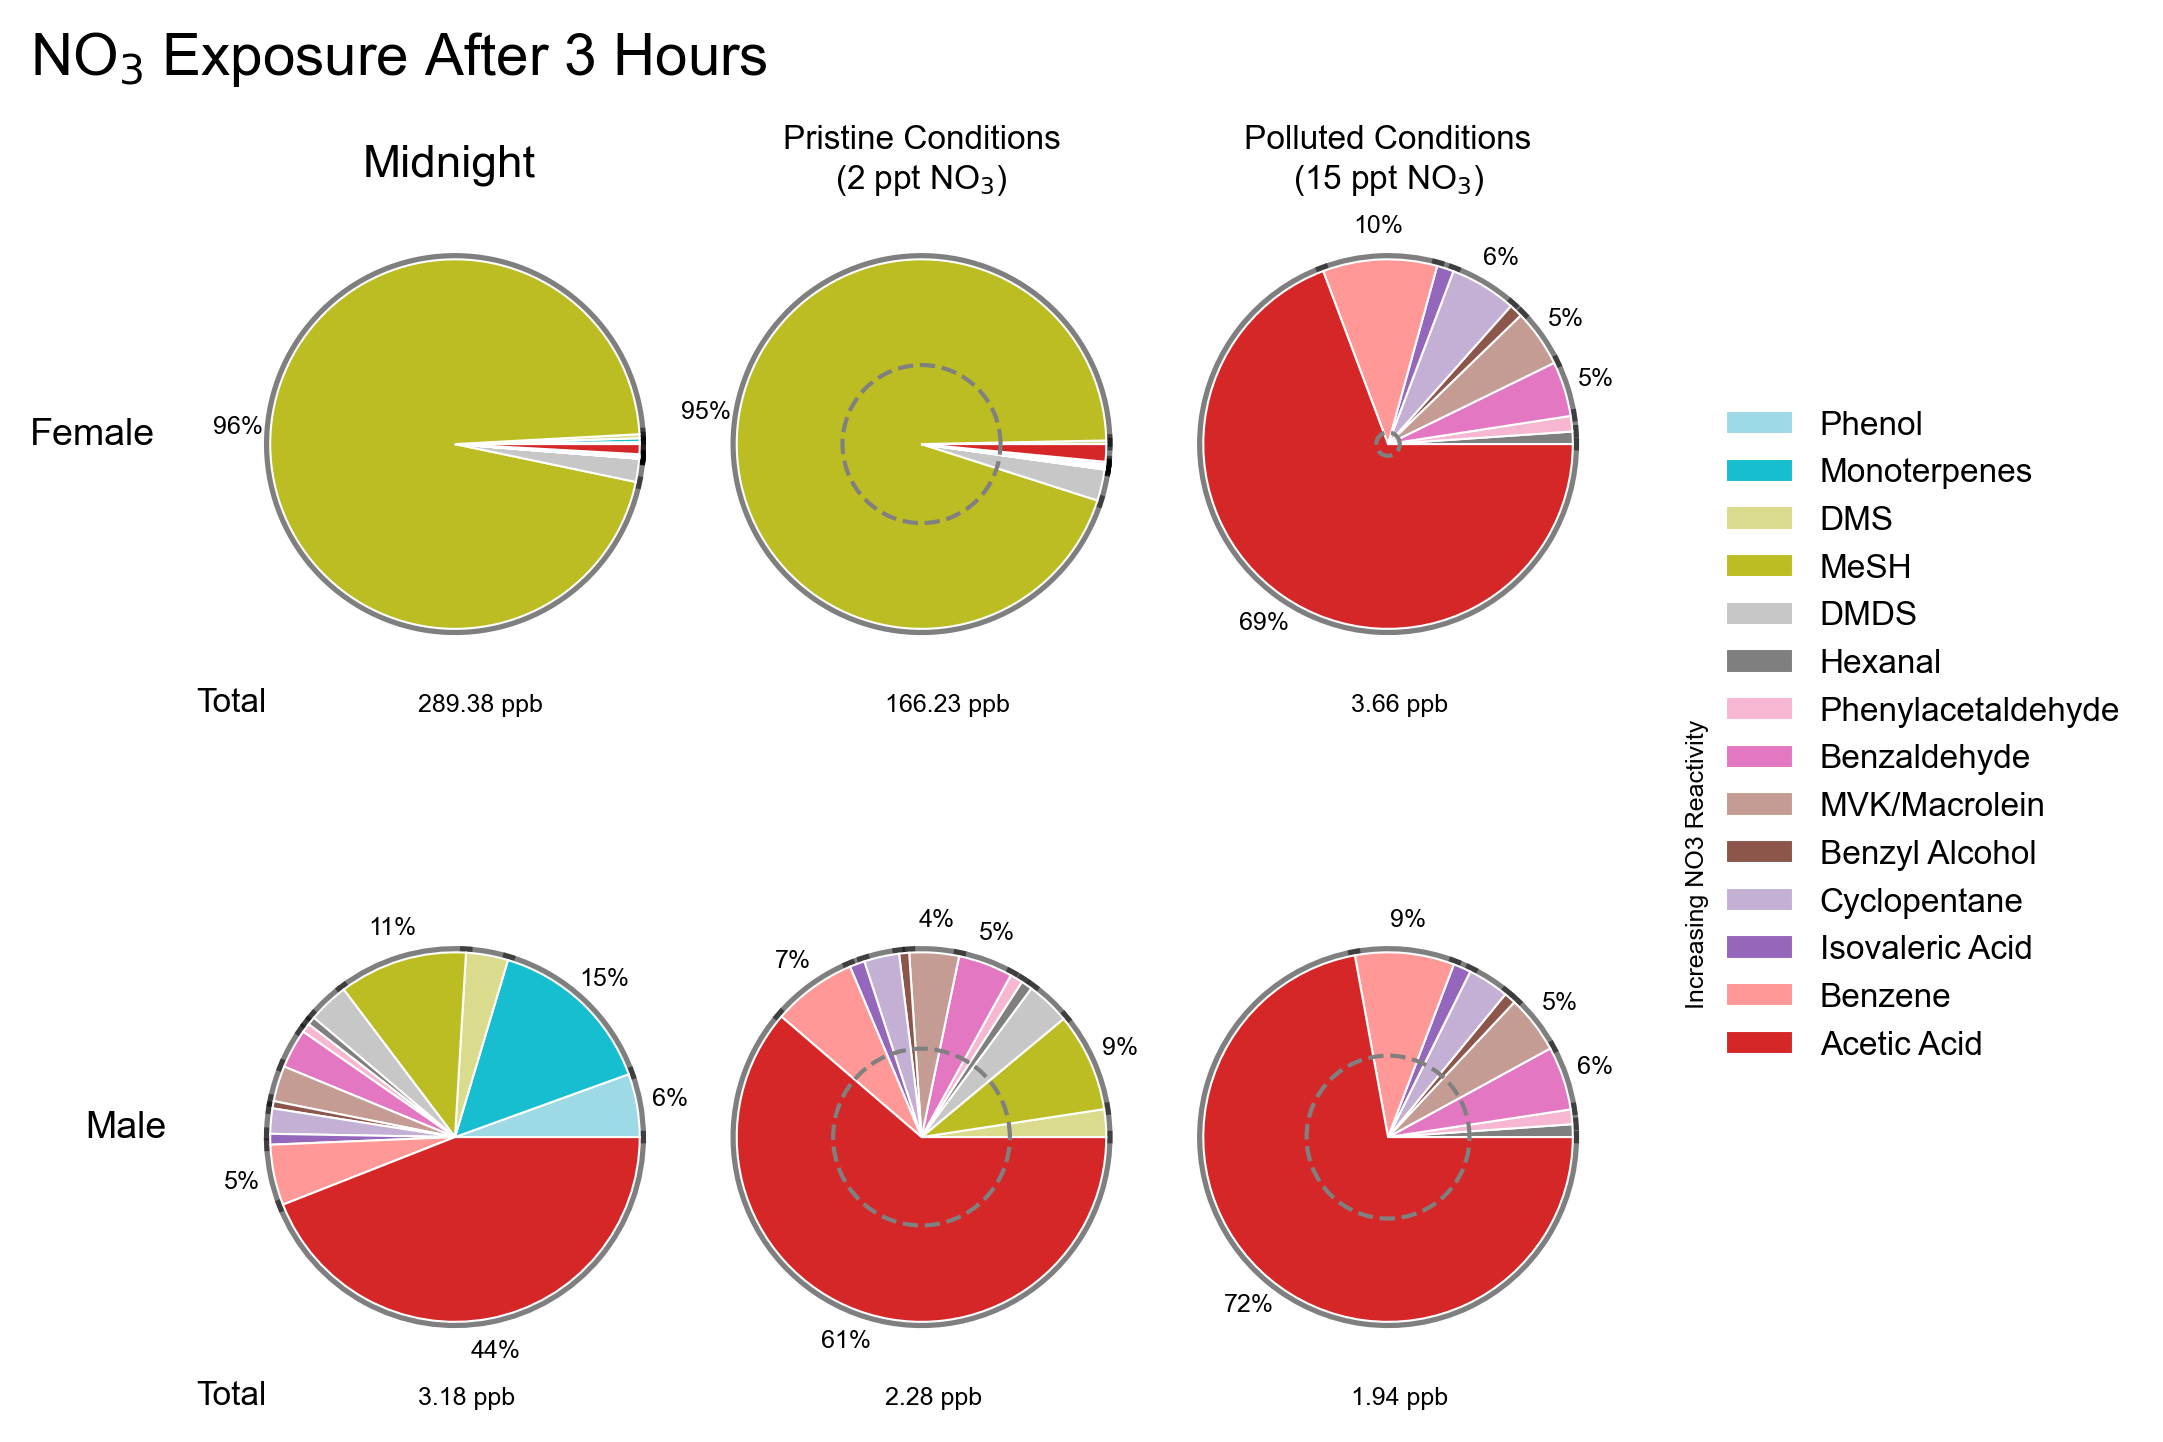

In [50]:
# creating the plot
colors = plt.cm.tab20_r.colors # pulling colors from a qualitative color map

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, 
                                                       ncols = 3, 
                                                       dpi = 300,
                                                      figsize = (6, 6))
# setting what I wanted plotted for the female plots
f_params = [
    {'data' : female_exposures['midnight_ppb'],
     'title' : ' '}, 
    {'data' : female_exposures['pristine_remaining_ppb'],
     'title' : 'Pristine Conditions\n(2 ppt NO$_{3}$)'},
    {'data' : female_exposures['polluted_remaining_ppb'],
    'title' : 'Polluted Conditions\n(15 ppt NO$_{3}$)'}
]
# now the male variables
m_params = [
    {'data' : male_exposures['midnight_ppb'],
    # 'title' : 'Midnight Concentrations'
    }, 
    {'data' : male_exposures['pristine_remaining_ppb'],
   #  'title' : 'After 1 Hour'
    },
    {'data' : male_exposures['polluted_remaining_ppb'],
     #'title' : 'After 3 Hours'
    }
]
 # creating the same female pie charts for the different data, pulling from f_params above
for ax, f_params in zip([ax1, ax2, ax3], f_params):
    ax.pie(f_params['data'], 
           colors = colors,
           autopct = lambda pct: '{:1.0f}%'.format(pct) if pct > 4 else '', # setting min for which slices will get % labels 
           textprops = {'fontsize' : 6},
           pctdistance = 1.18,
           rotatelabels = True,
           wedgeprops = {'edgecolor' : 'white', 'linewidth' : 0.5},
           shadow = {'edgecolor' : 'black', 'ox' : 0, 'oy' : 0, 'linewidth' : 3}, # faking an edge outline,
           radius = base_radius
          )
    ax.set_title(f_params['title'],
                fontsize = 8)

for ax, m_params in zip([ax4, ax5, ax6], m_params):
    ax.pie(m_params['data'], 
          colors = colors,
           autopct = lambda pct: '{:1.0f}%'.format(pct) if pct > 4 else '',
           textprops = {'fontsize' : 6},
           pctdistance = 1.18,
           rotatelabels = True,
           wedgeprops = {'edgecolor' : 'white', 'linewidth' : 0.5},
           shadow = {'edgecolor' : 'black', 'ox' : 0, 'oy' : 0, 'linewidth' : 3}, # faking an edge outline,
           radius = base_radius 
          )
             
ax1.text(x = -2.3,  y = 2,  # setting independent plot title\
         s =  'NO$_{3}$ Exposure After 3 Hours',
         fontsize = 14)
ax1.text(x = -2.3,  y = 0.0, 
         s =  'Female',
         fontsize = 9)
ax4.text(x = -2,  y = 0.0, 
         s =  'Male',
         fontsize = 9)
ax1.text(x = -0.5,  y = 1.45, 
         s =  'Midnight',
         fontsize = 11)

legend = ax3.legend( # one legend for all
    loc = 'right', 
    bbox_to_anchor = (2.15, 0.2),
    fontsize = 8,
    labels = female_exposures['proposed_cmpd_name'],
    title = 'Increasing NO3 Reactivity',
    title_fontsize = 6,
    alignment = 'right',
    frameon = False
)

# setting the legend title to vertical alignment
legend._legend_box.align = "left"
legend.get_title().set_position((-40, -615))
legend.get_title().set_rotation(90)

plt.subplots_adjust(wspace = 0.01, hspace = 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000001)

# adding smaller, secondary pie charts that are sized by total emissions
fake_data = [100]
scaling_factors = [
    {'radius' : female_radius_scale_factor_pristine * base_radius},
    {'radius' : female_radius_scale_factor_polluted * base_radius},
    {'radius' : male_radius_scale_factor_pristine * base_radius},
    {'radius' : male_radius_scale_factor_polluted * base_radius}
]
for ax, scaling_factors in zip([ax2, ax3, ax5, ax6], scaling_factors):
    ax.pie(fake_data,
           shadow = {'edgecolor' : 'black', 'ox' : 0, 'oy' : 0, 'linewidth' : 1, 'linestyle' : 'dashed'},
           radius =  scaling_factors['radius'],
           wedgeprops = {'fill' : None, 'linestyle' : 'dashed', 'edgecolor' : 'gray'}
          )
# adding totals underneath each  pie chart
texts = [
    {'text' : f"{female_exposures['midnight_ppb'].sum():0.2f}" + ' ppb'},
    {'text' : f"{female_exposures['pristine_remaining_ppb'].sum():0.2f}" + ' ppb'},
    {'text' : f"{female_exposures['polluted_remaining_ppb'].sum():0.2f}" + ' ppb'},
    {'text' : f"{male_exposures['midnight_ppb'].sum():0.2f}" + ' ppb'},
    {'text' : f"{male_exposures['pristine_remaining_ppb'].sum():0.2f}" + ' ppb'},
    {'text' : f"{male_exposures['polluted_remaining_ppb'].sum():0.2f}" + ' ppb'}
]
for ax, texts in zip([ax1, ax2, ax3, ax4, ax5, ax6], texts):
    ax.text(x = -0.2, y = -1.45,
            s = texts['text'],
            fontsize = 6
            )

for ax in [ax1, ax4]:
    ax.text(x = -1.4, y = -1.45,
            s = 'Total', 
            fontsize = 8)


save_path = 'C:\\Users\\rossellr\\OneDrive - Colostate\\Desktop\\CSU\\Research\\Research Projects\\Plants\\CORPSE\\Python\\Fig_Outputs'
fig_name = today + '_no3_exposures' + '.svg'

fig_save_path = save_path + "/" + fig_name
#plt.savefig(fname = fig_save_path, bbox_inches = 'tight') #keeps legend included when outputting figure

plt.show()
plt.close()


## Error Analysis

In [52]:
import datetime as datetime

# starting off easy w/ the CO2 data

co2_ts_copy = co2_ts.copy()

female_start = datetime.datetime(2024, 5, 25, 18, 0, 0)
female_end = datetime.datetime(2024, 5, 26, 9, 0, 0)

male_start = datetime.datetime(2024, 5, 26, 18, 0, 0)
male_end = datetime.datetime(2024, 5, 27, 9, 0, 0)

female_co2 = co2_ts_copy[(co2_ts_copy['datetime'] >= female_start) & (co2_ts_copy['datetime'] <= female_end)]
male_co2 = co2_ts_copy[(co2_ts_copy['datetime'] >= male_start) & (co2_ts_copy['datetime'] <= male_end)]

nighttime_co2 = pd.concat([female_co2, male_co2])
#print(nighttime_co2['Carbon dioxide(ppm)'].describe()) # getting descriptive stats 
#print(nighttime_co2['Temperature(°C)'].describe())
#print(nighttime_co2['Relative humidity(%)'].describe())

## Trying Something

In [54]:
female_ts

,datetime,CHS+,CH3OS+,C4H9OS+,C2H7O2S+,S2+,CH5S+,CH3S+,CH3S2+,CH3S3+,...,C8H15+,CH3O2+,C2H5O2+,C5H11O2+,C7H7O2+,C7H9O+,C8H9O+,C9H11O2+,C9H11O3+,C10H17+
0,2024-05-25 18:00:02,0.296404,0.002154,-0.033695,0.018434,-0.013538,0.136785,0.021611,0.023089,0.004005,...,0.043084,0.075131,2.42288,0.055868,0.058207,0.025865,0.044286,0.006959,0.005979,0.550536
1,2024-05-25 18:00:12,0.229522,0.002634,-0.033739,0.016881,-0.011913,0.187900,0.051087,0.025557,-0.003986,...,0.042710,0.070835,2.33977,0.052201,0.064341,0.029864,0.049128,0.004958,0.003865,0.575604
2,2024-05-25 18:00:22,0.235871,0.003397,-0.033784,0.020880,-0.014679,0.172885,0.038770,0.026030,0.000143,...,0.048476,0.061640,2.46406,0.055872,0.071021,0.030026,0.048135,0.007746,0.010448,0.646106
3,2024-05-25 18:00:32,0.269853,0.002391,-0.033828,0.018761,-0.014443,0.132529,0.008323,0.021232,0.004585,...,0.048392,0.055029,2.40452,0.052185,0.072441,0.034298,0.055107,0.008858,0.004757,0.655889
4,2024-05-25 18:00:42,0.237051,0.002396,-0.033872,0.020806,-0.007579,0.223317,0.056815,0.030968,-0.005923,...,0.044115,0.065808,2.57727,0.052881,0.068124,0.034476,0.050976,0.009351,0.005121,0.742790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5081,2024-05-26 08:59:13,0.210072,0.004440,-0.001912,0.133779,0.013033,0.910271,0.188184,0.054234,0.012013,...,0.058214,0.032766,1.48542,0.022043,0.015970,0.024637,0.037766,0.005606,0.001351,0.422033
5082,2024-05-26 08:59:23,0.189386,0.003644,-0.008054,0.137335,0.009539,0.441628,0.086659,0.041823,0.021072,...,0.058475,0.034324,1.45806,0.021385,0.019855,0.019188,0.037308,0.004561,0.005526,0.412265
5083,2024-05-26 08:59:33,0.125704,0.003142,-0.002920,0.140527,0.008268,0.425594,0.088620,0.036071,0.014561,...,0.053839,0.025165,1.36167,0.025229,0.015104,0.022353,0.033613,0.004692,0.002443,0.395844
5084,2024-05-26 08:59:43,0.042352,0.002671,-0.010113,0.097000,0.006426,0.267951,0.096259,0.041390,0.007644,...,0.054778,0.044690,1.30567,0.016696,0.020362,0.023938,0.032435,0.002408,0.004494,0.348702


Text(0, 0.5, 'VOSC (ppb)')

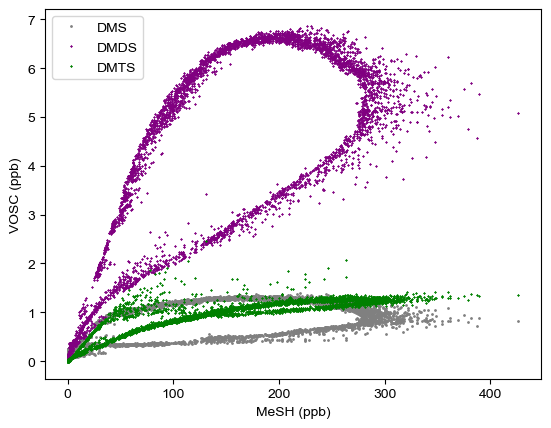

In [55]:
plt.plot(female_ts['CH5S+'], female_ts['C2H7S+'], label = 'DMS',
         linestyle = '', marker = 'o', color = 'gray', markersize = 1)

plt.plot(female_ts['CH5S+'], female_ts['C2H7S2+'], label = 'DMDS',
         linestyle = '', marker = 'x', color = 'purple', markersize = 1)

plt.plot(female_ts['CH5S+'], female_ts['C2H7S3+'], label = 'DMTS',
         linestyle = '', marker = 'x', color = 'green', markersize = 1)

plt.legend()
plt.xlabel('MeSH (ppb)')
plt.ylabel('VOSC (ppb)')

Text(0.5, 1.0, 'VOSCs:MeSH (Male Bloom)')

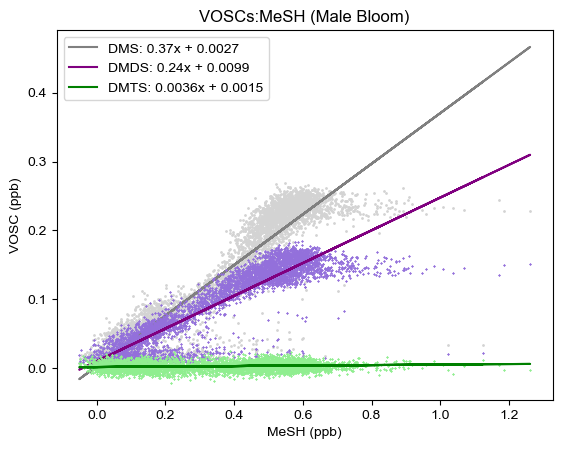

In [56]:
d = [male_ts['CH5S+'], male_ts['C2H7S+'], male_ts['C2H7S2+'], male_ts['C2H7S3+']]
VOSCs = pd.DataFrame(data = d)
VOSCs = VOSCs.transpose()
VOSCs = VOSCs.dropna()

x_linear = VOSCs[VOSCs.columns[0]]
x_linear = sm.add_constant(x_linear)

slopes = []
intercepts = []

for col in VOSCs.columns:   
    y_linear = VOSCs[col]
    model = sm.OLS(y_linear, x_linear)
    results = model.fit()
    intercept = results.params.iloc[0]
    slope = results.params.iloc[1]
    r2 = results.rsquared
    
    slopes.append(slope) # store in the list
    intercepts.append(intercept)

fig,ax = plt.subplots()

plt.plot(male_ts['CH5S+'], male_ts['C2H7S+'], 
         linestyle = '', marker = 'o', color = 'lightgray', markersize = 1)
plt.plot(male_ts['CH5S+'], (slopes[1] * male_ts['CH5S+'] + intercepts[1]), 
        color = 'gray', label = f"DMS: {slopes[1]:0.2}x + {intercepts[1]:0.2}")

plt.plot(male_ts['CH5S+'], male_ts['C2H7S2+'], 
         linestyle = '', marker = 'x', color = 'mediumpurple', markersize = 1)#
plt.plot(male_ts['CH5S+'], (slopes[2] * male_ts['CH5S+'] + intercepts[2]), 
        color = 'purple', label = f"DMDS: {slopes[2]:0.2}x + {intercepts[2]:0.2}")

plt.plot(male_ts['CH5S+'], male_ts['C2H7S3+'], 
         linestyle = '', marker = 'x', color = 'lightgreen', markersize = 1)
plt.plot(male_ts['CH5S+'], (slopes[3] * male_ts['CH5S+'] + intercepts[3]), 
        color = 'green', label = f"DMTS: {slopes[3]:0.2}x + {intercepts[3]:0.2}")

plt.legend()
plt.xlabel('MeSH (ppb)')
plt.ylabel('VOSC (ppb)')
plt.title('VOSCs:MeSH (Male Bloom)')



Text(0.5, 1.0, 'VOSCs:MeSH (Female Bloom)')

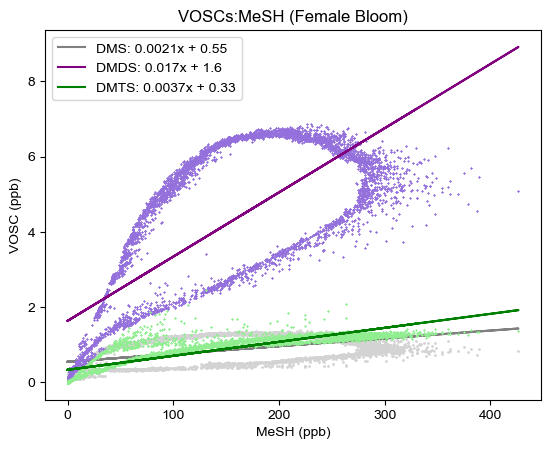

In [57]:
d = [female_ts['CH5S+'], female_ts['C2H7S+'], female_ts['C2H7S2+'], female_ts['C2H7S3+']]
VOSCs = pd.DataFrame(data = d)
VOSCs = VOSCs.transpose()
VOSCs = VOSCs.dropna()

x_linear = VOSCs[VOSCs.columns[0]]
x_linear = sm.add_constant(x_linear)

slopes = []
intercepts = []

for col in VOSCs.columns:   
    y_linear = VOSCs[col]
    model = sm.OLS(y_linear, x_linear)
    results = model.fit()
    intercept = results.params.iloc[0]
    slope = results.params.iloc[1]
    r2 = results.rsquared
    
    slopes.append(slope) # store in the list
    intercepts.append(intercept)



plt.plot(female_ts['CH5S+'], female_ts['C2H7S+'], 
         linestyle = '', marker = 'o', color = 'lightgray', markersize = 1)
plt.plot(female_ts['CH5S+'], (slopes[1] * female_ts['CH5S+'] + intercepts[1]), 
        color = 'gray', label = f"DMS: {slopes[1]:0.2}x + {intercepts[1]:0.2}")

plt.plot(female_ts['CH5S+'], female_ts['C2H7S2+'], 
         linestyle = '', marker = 'x', color = 'mediumpurple', markersize = 1)
plt.plot(female_ts['CH5S+'], (slopes[2] * female_ts['CH5S+'] + intercepts[2]), 
        color = 'purple', label = f"DMDS: {slopes[2]:0.2}x + {intercepts[2]:0.2}")

plt.plot(female_ts['CH5S+'], female_ts['C2H7S3+'], 
         linestyle = '', marker = 'x', color = 'lightgreen', markersize = 1)
plt.plot(female_ts['CH5S+'], (slopes[3] * female_ts['CH5S+'] + intercepts[3]), 
        color = 'green', label = f"DMTS: {slopes[3]:0.2}x + {intercepts[3]:0.2}")

plt.legend()
plt.xlabel('MeSH (ppb)')
plt.ylabel('VOSC (ppb)')
plt.title('VOSCs:MeSH (Female Bloom)')